Rohlik Sales Forecasting Challenge (ARIMA, LGBMRegressor, RNN)

In this project, the goal is to tackle the Rohlik sales forecasting challenge, an online retailer scenario. The primary objective is to predict the daily sales volume for a set of specific products (unique_id) across various warehouses, taking into account historical, economic, and temporal factors that influence demand.

The prediction will be performed for the test dataset (sales_test.csv), using a model based on historical sales data and complementary features provided in the supplied files. The model's performance will be evaluated using a weighted metric based on the importance of each product (test_weights.csv).









In [1]:
!pip install darts[torch] scikit-learn==1.2.2
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.3/963.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 33.8 MB/s eta 0:00:00

## Upload and Load Files in Colab

In [2]:
from google.colab import files
import pandas as pd

# Upload the files manually
uploaded = files.upload()


Saving test_weights.csv to test_weights.csv
Saving solution.csv to solution.csv
Saving sales_train_t.csv to sales_train_t.csv
Saving inventory.csv to inventory.csv
Saving calendar.csv to calendar.csv


In [3]:
# Load the data into pandas DataFrames
sales_train = pd.read_csv("sales_train_t.csv")
inventory = pd.read_csv("inventory.csv")
calendar = pd.read_csv("calendar.csv")
test_weights = pd.read_csv("test_weights.csv")
solution = pd.read_csv("solution.csv")


In [ ]:
# Load the data into pandas DataFrames
#sales_train = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_train.csv')
#inventory = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/inventory.csv')
#calendar = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/calendar.csv')
#test_weights = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/test_weights.csv')
#solution = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/solution.csv')


In [4]:
from IPython.display import display

# Display the first few rows of each file as tables
print("Sales Train Data:")
display(sales_train.head())

print("Inventory Data:")
display(inventory.head())

print("Calendar Data:")
display(calendar.head())

print("Test Weights Data:")
display(test_weights.head())


Sales Train Data:


,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,0.0,0.15312,0.0,0.0
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,0.0,0.15312,0.0,0.0
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,0.0,0.15649,0.0,0.0


Inventory Data:


,unique_id,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse
0,5255,2583,Pastry_196,Bakery,Bakery_L2_14,Bakery_L3_26,Bakery_L4_1,Prague_3
1,4948,2426,Herb_19,Fruit and vegetable,Fruit and vegetable_L2_30,Fruit and vegetable_L3_86,Fruit and vegetable_L4_1,Prague_3
2,2146,1079,Beet_2,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_65,Fruit and vegetable_L4_34,Prague_1
3,501,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_1
4,4461,2197,Chicory_1,Fruit and vegetable,Fruit and vegetable_L2_17,Fruit and vegetable_L3_33,Fruit and vegetable_L4_1,Frankfurt_1


Calendar Data:


,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse
0,2022-03-16,NaN,0,0,0,0,Frankfurt_1
1,2020-03-22,NaN,0,0,0,0,Frankfurt_1
2,2018-02-07,NaN,0,0,0,0,Frankfurt_1
3,2018-08-10,NaN,0,0,0,0,Frankfurt_1
4,2017-10-26,NaN,0,0,0,0,Prague_2


Test Weights Data:


,unique_id,weight
0,0,2.535369
1,1,3.888933
2,2,5.885237
3,3,2.139552
4,5,3.021715


## Data Analysis and Manipulation


In this part, we focus on understanding and preparing the datasets to be suitable for the predictive modeling task.
The sales_train.csv, calendar.csv, and inventory.csv datasets are the most relevant for predicting sales at the warehouse level.
The sales_train.csv file provides historical sales data, including key variables such as total_orders, sales, and sell_price_main, which are directly related to the target prediction.
In addition, calendar.csv contains valuable temporal information, such as holidays and school vacations, which can significantly affect sales patterns.
The inventory.csv file provides granular information about the inventory in the warehouses, as well as the name of the product in question as well as the categories to which it belongs.
We will also work with test_weights.csv which contains the weight associated with each product.

##Data Preprocessing

Several joins were performed between different data sets to combine relevant information. First, the sales set was combined with the inventory set using common columns as identifiers. Then, calendar information was added using columns such as warehouse and date. Finally, test weights data was added to the combined set using a unique identifier. The final result contains unified data from all these sources, preserving rows based on the join type specified at each step.

In [5]:
import pandas as pd

# Perform the merge using unique_id and warehouse
sales_train_inventory = pd.merge(
    sales_train,
    inventory,
    on=["unique_id", "warehouse"],
    how="inner"  # Change to "left", "right", or "outer" based on requirements
)

sales_train_inventory_calendar = pd.merge(
    sales_train_inventory,
    calendar,
    on=["warehouse", "date"],
    how="left"  # Use "left" to keep all rows from merged_data
)

final_combined_data = pd.merge(
    sales_train_inventory_calendar,
    test_weights,
    on="unique_id",
    how="left"  # Use "left" to keep all rows from final_data
)

# Display the first rows of the combined result
print(final_combined_data.columns)
print(final_combined_data.shape)
final_combined_data.head()


Index(['unique_id', 'date', 'warehouse', 'total_orders', 'sales',
       'sell_price_main', 'availability', 'type_0_discount', 'type_1_discount',
       'type_2_discount', 'type_3_discount', 'type_4_discount',
       'type_5_discount', 'type_6_discount', 'product_unique_id', 'name',
       'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en',
       'L4_category_name_en', 'holiday_name', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'weight'],
      dtype='object')
(1048575, 26)


,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,weight
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,...,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NaN,0,0,0,0,1.925596
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,...,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NaN,0,0,0,0,1.925596
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,...,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NaN,0,0,0,0,1.925596
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,...,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NaN,0,0,0,0,1.925596
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,...,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NaN,0,0,0,0,1.925596


The final dataset was sorted by the unique_id, date, and warehouse columns in ascending order. And also we check for duplicates based on unique_id, date, and warehouse

In [6]:
# Organize the final dataset by unique_id, date, and warehouse
final_combined_data = final_combined_data.sort_values(by=["unique_id", "date", "warehouse"])

# Check for duplicates based on unique_id, date, and warehouse
duplicates = final_combined_data.duplicated(subset=["unique_id", "date", "warehouse"])
if duplicates.any():
    print("Duplicates found:")
    print(final_combined_data[duplicates])
else:
    print("No duplicates found.")

# Check the first rows of the organized dataset
final_combined_data.head()



null_check = final_combined_data.isnull().sum()
print(null_check)

No duplicates found.
unique_id                       0
date                            0
warehouse                       0
total_orders                   19
sales                          19
sell_price_main                 0
availability                    0
type_0_discount                 0
type_1_discount                 0
type_2_discount                 0
type_3_discount                 0
type_4_discount                 0
type_5_discount                 0
type_6_discount                 0
product_unique_id               0
name                            0
L1_category_name_en             0
L2_category_name_en             0
L3_category_name_en             0
L4_category_name_en             0
holiday_name              1006378
holiday                         0
shops_closed                    0
winter_school_holidays          0
school_holidays                 0
weight                          0
dtype: int64


The function checks for missing dates for each combination of unique_id and warehouse. When dates are missing in the dataset, the model might interpret the gaps as missing values ​​or might not be able to make the prediction correctly, which would affect the accuracy of the model.

In [7]:
# Convert 'date' to datetime and check for missing dates by unique_id and warehouse
final_combined_data['date'] = pd.to_datetime(final_combined_data['date'])

missing_dates_report = [
    {'unique_id': unique_id, 'warehouse': warehouse, 'missing_dates': sorted(set(pd.date_range(group['date'].min(), group['date'].max(), freq='D')) - set(group['date']))}
    for (unique_id, warehouse), group in final_combined_data.groupby(['unique_id', 'warehouse'])
    if set(pd.date_range(group['date'].min(), group['date'].max(), freq='D')) - set(group['date'])
]

# Report results
if missing_dates_report:
    for report in missing_dates_report:
        print(f"Unique ID: {report['unique_id']}, Warehouse: {report['warehouse']}, Missing Dates: {report['missing_dates']}")
else:
    print("No missing dates found.")



Output hidden; open in https://colab.research.google.com to view.

The dataset was checked for missing dates for each combination of unique_id and warehouse. The missing dates were generated and inserted as new rows in the dataset, using the previous day's values ​​for the other columns. The rows were then reordered to maintain the proper order of unique_id, date, and warehouse, and the first rows of the updated dataset were printed.


In [8]:
import pandas as pd

# Convert 'date' to datetime format
final_combined_data['date'] = pd.to_datetime(final_combined_data['date'])

# Initialize an empty list to store rows to be added
rows_to_add = []

# Iterate over each combination of unique_id and warehouse
for (unique_id, warehouse), group in final_combined_data.groupby(['unique_id', 'warehouse']):
    # Ensure the DataFrame is sorted by date
    group = group.sort_values(by='date')

    # Generate the complete date range within the group's range
    full_date_range = pd.date_range(group['date'].min(), group['date'].max(), freq='D')

    # Identify missing dates
    missing_dates = set(full_date_range) - set(group['date'])

    # For each missing date, add a row with data from the previous day
    for missing_date in sorted(missing_dates):
        # Get the data from the previous day
        previous_day_data = group[group['date'] < missing_date].iloc[-1].to_dict()

        # Update the date to the missing date
        previous_day_data['date'] = missing_date

        # Add the new row to the list of rows to be added
        rows_to_add.append(previous_day_data)

# Create a DataFrame with the new rows and append it to the original dataset
if rows_to_add:
    new_rows_df = pd.DataFrame(rows_to_add)
    final_combined_data = pd.concat([final_combined_data, new_rows_df], ignore_index=True)

# Reorder the dataset by unique_id, date, and warehouse
final_combined_data = final_combined_data.sort_values(by=["unique_id", "date", "warehouse"]).reset_index(drop=True)

# Print the first few rows of the updated DataFrame
print(final_combined_data.head())




   unique_id       date warehouse  total_orders  sales  sell_price_main  \
0          6 2021-08-11  Munich_1         694.0   4.94              1.8   
1          6 2021-08-12  Munich_1         894.0   0.00              1.8   
2          6 2021-08-13  Munich_1        1338.0   4.86              1.8   
3          6 2021-08-14  Munich_1         581.0   7.45              1.8   
4          6 2021-08-15  Munich_1         547.0   9.60              1.8   

   availability  type_0_discount  type_1_discount  type_2_discount  ...  \
0          0.95              0.0              0.0              0.0  ...   
1          1.00              0.0              0.0              0.0  ...   
2          1.00              0.0              0.0              0.0  ...   
3          1.00              0.0              0.0              0.0  ...   
4          1.00              0.0              0.0              0.0  ...   

   L1_category_name_en       L2_category_name_en       L3_category_name_en  \
0  Fruit and vegetab

Check for nulls and zeros in the specified columns

In [9]:
# Check for nulls and zeros
print(final_combined_data[['total_orders', 'sales', 'sell_price_main']].isnull().sum())
final_combined_data[['total_orders', 'sales', 'sell_price_main']] = final_combined_data[['total_orders', 'sales', 'sell_price_main']].fillna(0)


total_orders       140
sales              140
sell_price_main      0
dtype: int64


In [10]:
print((final_combined_data[['total_orders', 'sales', 'sell_price_main']] == 0).sum())


total_orders         140
sales              14306
sell_price_main        0
dtype: int64


Now it identifies the rows where "sales" is 0 and checks if this is unjustified by checking if any of the columns "holidays", "stores_closed", "winter_school_holidays", "school_holidays" have a value of 1. In case of unjustified zeros, it updates the value of "sales" with the previous day's "sales" from the same store group and unique_id. The dataset is then updated with the corrected values.

In [11]:
# Columns to check
target_columns = ['sales']
condition_columns = ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']

# Filter rows where 'sales' is zero
zeros_data = final_combined_data[(final_combined_data[target_columns] == 0).any(axis=1)]

# Update 'sales' with the previous day's value if conditions are not met
for idx, row in zeros_data.iterrows():
    # Check if the conditions are not justified
    if row[condition_columns].sum() == 0:
        # Get the corresponding group (unique_id, warehouse)
        group = final_combined_data[
            (final_combined_data['unique_id'] == row['unique_id']) &
            (final_combined_data['warehouse'] == row['warehouse'])
        ]
        # Find the previous day's sales (if it exists)
        previous_day_group = group[group['date'] < row['date']].sort_values('date')
        if not previous_day_group.empty:
            previous_day = previous_day_group.iloc[-1]['sales']
            # Update the 'sales' value
            final_combined_data.loc[idx, 'sales'] = previous_day
        else:
            # Handle the case where there's no previous day's data, e.g., set to a default value
            final_combined_data.loc[idx, 'sales'] = 0  # or another suitable default


# Dataset is now updated



Now we identify and display the data types of each column in the dataset.

In [12]:
# Get data types of each column
data_types = final_combined_data.dtypes

# Display the results
print(data_types)


unique_id                          int64
date                      datetime64[ns]
warehouse                         object
total_orders                     float64
sales                            float64
sell_price_main                  float64
availability                     float64
type_0_discount                  float64
type_1_discount                  float64
type_2_discount                  float64
type_3_discount                  float64
type_4_discount                  float64
type_5_discount                  float64
type_6_discount                  float64
product_unique_id                  int64
name                              object
L1_category_name_en               object
L2_category_name_en               object
L3_category_name_en               object
L4_category_name_en               object
holiday_name                      object
holiday                            int64
shops_closed                       int64
winter_school_holidays             int64
school_holidays 

We will check whether all variables are necessary by examining the correlation of the independent variables with the target variable. This step is essential to ensure that we only use relevant features for the model and eliminate any redundant or irrelevant variables.

The strongest positive correlation with sales is observed for type_0_discount (0.43), suggesting that this discount type significantly influences sales.
Negative correlations, such as with type_6_discount (-0.07) and availability (-0.04), indicate these variables might inversely affect sales, but their effects are relatively weak.

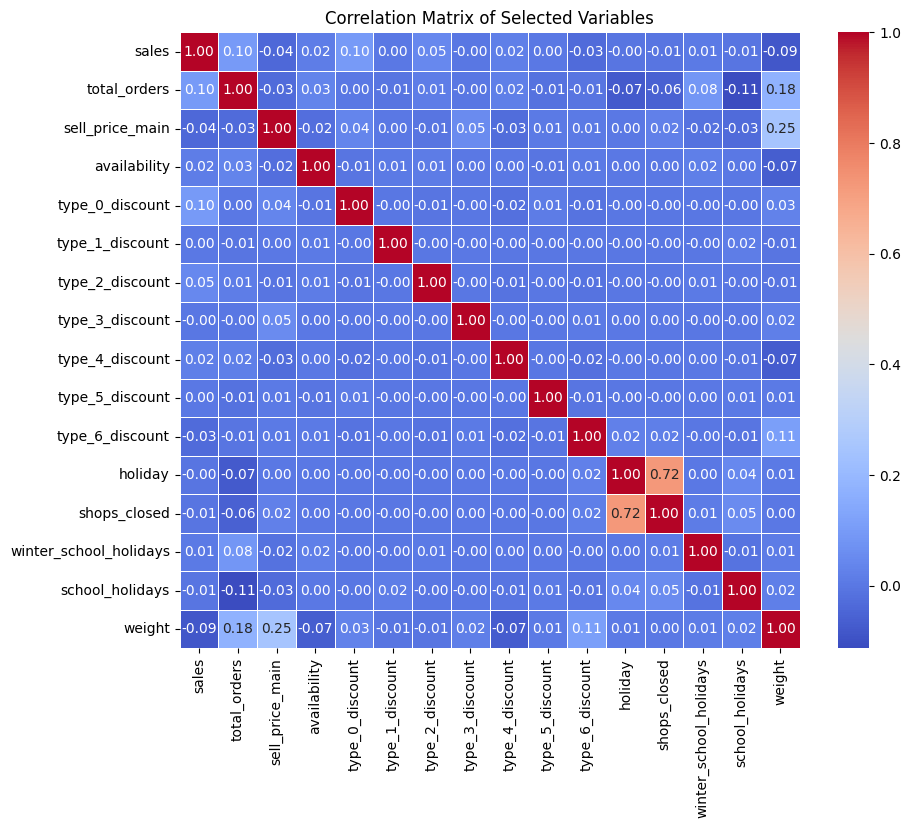

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the relevant columns
selected_columns = ['sales','total_orders', 'sell_price_main', 'availability',
                    'type_0_discount', 'type_1_discount', 'type_2_discount',
                    'type_3_discount', 'type_4_discount', 'type_5_discount',
                    'type_6_discount', 'holiday', 'shops_closed',
                    'winter_school_holidays', 'school_holidays', 'weight']

#Calculate the correlation matrix
correlation_matrix = final_combined_data[selected_columns].corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Selected Variables')
plt.show()

Conclusion of the analysis: the variables present little or insignificant correlations with the sales variables.
The ARIMA model is appropriate since no variables have been identified in the dataset that have a significant correlation with sales. ARIMA (Autoregressive Integrated Moving Average) is based on the historical values ​​of the target variable (sales, in this case) to model temporal patterns such as trends, seasonality and past dependencies. In this case we will apply it for monthly sales by Warehouse since applying it for each product is analyzing a historical series by product. Later, other algorithms will be applied to analyze sales by product.

#BASICS OF FORECASTING MODELS (ARIMA)

Building an ARIMA model requires extensive exploratory analysis. This critical step serves as a compass, guiding the analyst toward a detailed understanding of the intrinsic dynamics of the data. Before training an ARIMA model on a time series, it is important to perform exploratory analysis to determine, at a minimum, the following:


1. Stationarity: Stationarity means that statistical properties (mean, variance, etc.) remain constant over time, so time series with trends or seasonality are not stationary. Since ARIMA assumes stationarity of the data, it is essential to subject the data to rigorous testing, such as the Augmented Dickey-Fuller test, to assess that this is true. If non-stationarity is found, the series should be differenced until stationarity is achieved. This analysis helps determine the optimal value of the parameter d
2. Autocorrelation analysis: Plot the autocorrelation and partial autocorrelation functions (ACF and PACF) to identify possible lag relationships between values ​​in the series. This visual analysis helps determine the appropriate autoregressive (AR) and moving average (MA) terms ( p
and q) for the ARIMA model.

3. Seasonal decomposition: In cases where seasonality is suspected, decomposing the series into trend, seasonal, and residual components using techniques such as moving averages and seasonal time series decomposition (STL) can reveal hidden patterns and help identify seasonality. This analysis helps determine the optimal values ​​for the parameters P, D, Q, and m.

These exploratory analyses lay the foundation for beginning to build an effective ARIMA model that captures the fundamental patterns and associations within the data.



In [ ]:
# Filter relevant columns
data_filtered = final_combined_data[['date', 'sales', 'warehouse']]

# Filter data up to May 2023
data_filtered = data_filtered[data_filtered['date'] <= '2024-05-31']

# Group by warehouse and month, summing monthly sales
monthly_sales_warehouse = data_filtered.groupby(
    ['warehouse', pd.Grouper(key='date', freq='D')]
)['sales'].sum().reset_index()

# Plot interactive line chart
import plotly.express as px
fig = px.line(
    monthly_sales_warehouse,
    x='date',
    y='sales',
    color='warehouse',
    title='Monthly Sales by Warehouse (Up to May 2023)',
    labels={'sales': 'Sales', 'date': 'Date', 'warehouse': 'Warehouse'}
)
fig.update_layout(xaxis_title='Date', yaxis_title='Sales', legend_title='Warehouse', hovermode='x unified')
fig.show()


Python libraries

In [ ]:
#!pip install pandas matplotlib statsmodels numpy
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

## Stationary
For ARIMA, the time series data should be stationary. You can check the stationarity using the Augmented Dickey-Fuller (ADF) test. If the p-value is less than 0.05, the data is stationary.
The KPSS test focuses on the presence of trends. A low p-value indicates non-stationarity due to a trend.
The graph generated in the previous section shows several negative and positive trends, indicating constant variation over time. As a result, the mean of the series increases and decreases over time.

Differencing to Achieve Stationarity: If the data is not stationary, you may need to difference it (subtract the previous value from the current value). This process can be repeated until the series becomes stationary.

The first difference is calculated as:

ΔXt=Xt−Xt−1

Where Xt is the value at time t and Xt−1 is the value at time t−1 . This is known as first-order differentiation. This process can be repeated if necessary until the desired stationarity is reached.

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*InterpolationWarning.*")

# Prepare a dictionary to store results for both tests
stationarity_results = {}

# Loop through each warehouse and perform both KPSS and ADF tests
for warehouse in monthly_sales_warehouse['warehouse'].unique():
    # Filter the data for the warehouse
    warehouse_data = monthly_sales_warehouse[monthly_sales_warehouse['warehouse'] == warehouse]

    # Extract sales values
    sales_series = warehouse_data['sales']

    # Perform the ADF test
    adf_result = adfuller(sales_series)



    # Store the results for both tests
    stationarity_results[warehouse] = {
        'ADF Statistic': adf_result[0],
        'ADF p-value': adf_result[1],
        'ADF Stationary': adf_result[1] < 0.05,  # Stationary if p-value < 0.05
    }

# Prepare a list to store the results
results_list = []

# Loop through each warehouse and perform both KPSS and ADF tests
for warehouse, result in stationarity_results.items():
    # Create a dictionary for the current warehouse results
    results_list.append({
        'Warehouse': warehouse,
        'ADF Statistic': result['ADF Statistic'],
        'ADF p-value': result['ADF p-value'],
        'ADF Stationary': 'Yes' if result['ADF Stationary'] else 'No',
    })

# Convert the results into a DataFrame
results_df = pd.DataFrame(results_list)

# Display the results table
print(results_df)



     Warehouse  ADF Statistic  ADF p-value ADF Stationary
0       Brno_1      -3.726153     0.003760            Yes
1   Budapest_1      -3.740406     0.003579            Yes
2  Frankfurt_1      -2.773334     0.062185             No
3     Munich_1      -2.557942     0.102005             No
4     Prague_1      -2.953487     0.039472            Yes
5     Prague_2      -2.872911     0.048590            Yes
6     Prague_3      -2.883248     0.047331            Yes


Most warehouses exhibit stationarity according to the ADF test results. Specifically, Brno_1, Budapest_1, Prague_1, and Prague_2 are considered stationary, while Frankfurt_1 and Prague_3 are not. As for Munich_1, although its p-value is low (0.011), its interpretation may depend on the chosen threshold. The corresponding p-values are: Brno_1 (0.000007), Budapest_1 (0.002693), Frankfurt_1 (0.333635), Munich_1 (0.011396), Prague_1 (0.009100), Prague_2 (0.023009), and Prague_3 (0.071223). This indicates that, according to the ADF test, most warehouses demonstrate stationarity, except for Frankfurt_1 and Prague_3.

In [ ]:
# Calculate first difference and remove NaN for 'Brno_1'
brno_1_diff = monthly_sales_warehouse[monthly_sales_warehouse['warehouse'] == 'Brno_1'].copy()
brno_1_diff['sales_diff'] = brno_1_diff['sales'].diff()

# Drop NaN values from the 'sales_diff' column
brno_1_diff = brno_1_diff.dropna(subset=['sales_diff'])

# Plot original and first difference sales
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Original Sales - Brno_1", "First Difference - Brno_1"]
)

fig.add_trace(go.Scatter(x=brno_1_diff['date'], y=brno_1_diff['sales'], mode='lines', name="Original Sales"), row=1, col=1)
fig.add_trace(go.Scatter(x=brno_1_diff['date'], y=brno_1_diff['sales_diff'], mode='lines', name="First Difference"), row=1, col=2)

fig.update_layout(height=600, width=1200, title_text="Original and First Difference of Monthly Sales for Brno_1", title_x=0.5)
fig.show()

# Perform ADF test on the first difference of sales
adf_result = adfuller(brno_1_diff['sales_diff'])
adf_stat, adf_pvalue = adf_result[0], adf_result[1]
adf_stationary = adf_pvalue < 0.05

print(f"ADF Statistic: {adf_stat}")
print(f"ADF p-value: {adf_pvalue}")
print(f"Is the series stationary? {adf_stationary}")


ADF Statistic: -11.48670215436908
ADF p-value: 4.846012740473453e-21
Is the series stationary? True


## ACF and PACF
The plot of the autocorrelation function (ACF) and partial autocorrelation function (PACF) of the time series provides useful information about possible suitable values ​​of p and q. The ACF helps to identify the value of q (lags in the moving average part), while the PACF helps to identify the value of p (lags in the autoregressive part).

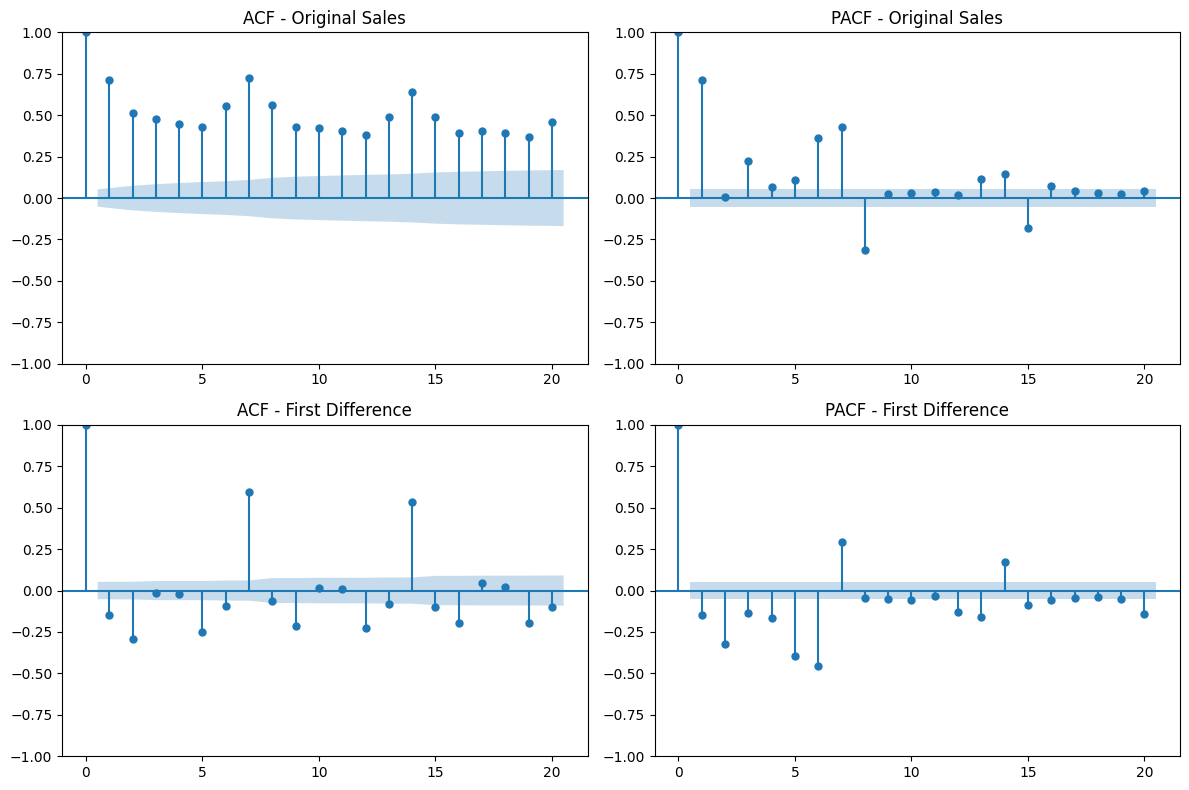

In [ ]:


# Plot ACF and PACF for original and differenced series
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# ACF and PACF for original sales
plot_acf(brno_1_diff['sales'], lags=20, ax=ax[0, 0], title="ACF - Original Sales")
plot_pacf(brno_1_diff['sales'], lags=20, ax=ax[0, 1], title="PACF - Original Sales")

# ACF and PACF for first differenced sales
plot_acf(brno_1_diff['sales_diff'], lags=20, ax=ax[1, 0], title="ACF - First Difference")
plot_pacf(brno_1_diff['sales_diff'], lags=20, ax=ax[1, 1], title="PACF - First Difference")

plt.tight_layout()
plt.show()



## Analysis for Warehouse Brno_1 (Example)
We filter sales data for the period between the years 2021 and 2023, ensuring that there is enough data to perform a seasonal decomposition. The decomposition separates the time series into components such as trend, seasonality, and noise.

(1095, 4)


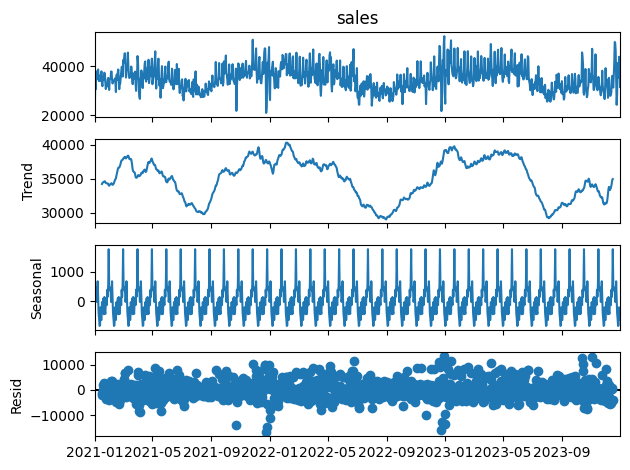

     warehouse       date     sales  sales_diff
153     Brno_1 2021-01-01  22397.55    -6037.22
154     Brno_1 2021-01-02  33100.54    10702.99
155     Brno_1 2021-01-03  30644.21    -2456.33
156     Brno_1 2021-01-04  37912.46     7268.25
157     Brno_1 2021-01-05  34571.79    -3340.67
...        ...        ...       ...         ...
1243    Brno_1 2023-12-27  35771.49    -5461.70
1244    Brno_1 2023-12-28  35271.60     -499.89
1245    Brno_1 2023-12-29  43870.57     8598.97
1246    Brno_1 2023-12-30  43269.07     -601.50
1247    Brno_1 2023-12-31  31507.27   -11761.80

[1095 rows x 4 columns]


In [ ]:

# Filter data for the years 2021 to 2023
brno_1_filtered = brno_1_diff[(brno_1_diff['date'] >= '2021-01-01') & (brno_1_diff['date'] <= '2023-12-31')]

# Ensure there are enough observations for decomposition
print(brno_1_filtered.shape)

# Perform seasonal decomposition with the adjusted period
brno_1_series = brno_1_filtered[['date', 'sales']].set_index('date')
result = seasonal_decompose(brno_1_series['sales'], model='additive', period=30)

# Plot the decomposition
result.plot()
plt.show()

print(brno_1_filtered)



In this code block, three ARIMA models with different parameter settings are fit to analyze sales time series. The ARIMA models are fit to capture patterns in the data and make predictions, using combinations of the parameters p (autoregressive), d (difference), and q (moving average). After each model is fit, a summary of the results for each model is printed, allowing you to compare their performance and determine which one best fits the sales data.

In [ ]:
# Fit an ARIMA model
# Using p=1, d=1, q=1 as an example, but you can adjust based on ACF/PACF analysis
model_1_0_1 = ARIMA(brno_1_diff['sales'], order=(1, 0, 1))
model_1_0_1 = model_1_0_1.fit()

model_0_0_1 = ARIMA(brno_1_diff['sales'], order=(0, 0, 1))
model_0_0_1 = model_0_0_1.fit()

model_1_0_0 = ARIMA(brno_1_diff['sales'], order=(1, 0, 0))
model_1_0_0 = model_1_0_0.fit()


print(model_1_0_1.summary())
print(model_0_0_1.summary())
print(model_1_0_0.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of inde

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1399
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -13587.962
Date:                Sat, 25 Jan 2025   AIC                          27183.924
Time:                        19:23:24   BIC                          27204.898
Sample:                             0   HQIC                         27191.765
                               - 1399                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.463e+04    401.296     86.288      0.000    3.38e+04    3.54e+04
ar.L1          0.7283      0.025     29.116      0.000       0.679       0.777
ma.L1         -0.0200      0.039     -0.520      0.6


**AIC (Akaike Information Criterion):**
The lower AIC indicates a better balance between the model fit and its complexity.

    - ARIMA(1,0,1) model: AIC = 27183.924
    - ARIMA(0,0,1) model: AIC = 27477.783
    - ARIMA(1,0,0) model: AIC = 27182.021

The ARIMA(1,1,1) model has the lowest AIC, so it is the preferred model according to this criterion.

**Goodness of fit (coefficients and significance):**
   * In the ARIMA(1,0,1) model: The AR (ar.L1) and MA (ma.L1) coefficients are statistically significant (p-value < 0.05).
   * In the ARIMA(0,0,1) model: The MA (ma.L1) coefficient is also significant (p-value < 0.05).
   * In the ARIMA(1,0,0) model: The AR coefficient (ar.L1) is significant (p-value < 0.05).

All models have significant parameters, but ARIMA(1,1,1) is more flexible by including both AR and MA components.

**Residuals (Ljung-Box and Jarque-Bera tests):**
Ljung-Box (L1) (Q):

   * ARIMA(1,01,1): Prob(Q) = 0.97 → There is no autocorrelation in the residuals.
   * ARIMA(0,0,1): Prob(Q) = 0.00 → There is autocorrelation in the residuals.
   * ARIMA(1,0,0): Prob(Q) = 0.82 → There is autocorrelation in the residuals.

ARIMA(1,0,1) and ARIMA(1,0,0) perform better in this test.

Jarque-Bera:
**bold text**
All models show residuals with normal distribution (p-value > 0.05), although ARIMA(1,0,1) has the best overall balance.
Conclusion:
The ARIMA(1,0,1) model is the best option considering

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



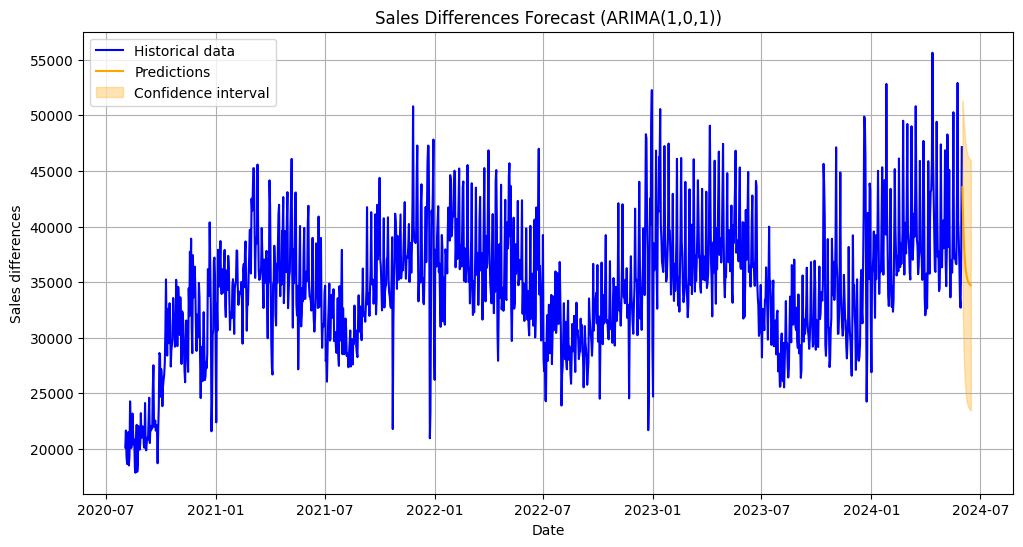

           date      forecast   lower_bound   upper_bound
1399 2024-06-01  43530.800975  35714.466070  51347.135880
1400 2024-06-02  41111.595466  31533.345995  50689.844937
1401 2024-06-03  39349.693012  28957.436739  49741.949285
1402 2024-06-04  38066.503037  27267.358075  48865.648000
1403 2024-06-05  37131.958388  26123.094573  48140.822204
1404 2024-06-06  36451.331420  25332.834411  47569.828429
1405 2024-06-07  35955.632183  24779.420258  47131.844108
1406 2024-06-08  35594.615437  24387.911126  46801.319748
1407 2024-06-09  35331.687675  24108.843282  46554.532067
1408 2024-06-10  35140.197920  23908.801953  46371.593887
1409 2024-06-11  35000.736321  23764.807087  46236.665555
1410 2024-06-12  34899.166722  23660.833704  46137.499740
1411 2024-06-13  34825.193790  23585.585971  46064.801609
1412 2024-06-14  34771.319453  23531.035515  46011.603392
1413 2024-06-15  34732.082884  23491.440337  45972.725431


In [ ]:
# Load the dataset
data = brno_1_diff[['date', 'sales']]
brno_1 = pd.DataFrame(data)
brno_1['date'] = pd.to_datetime(brno_1['date'])
brno_1.set_index('date', inplace=True)

# Predictions for the next 12 months
n_steps = 15
forecast = model_1_0_1.get_forecast(steps=n_steps)
forecast_index = pd.date_range(brno_1.index[-1], periods=n_steps + 1, freq="D")[1:]
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(brno_1.index, brno_1['sales'], label="Historical data", color="blue")
plt.plot(forecast_index, forecast_values, label="Predictions", color="orange")
plt.fill_between(
    forecast_index,
    confidence_intervals.iloc[:, 0],
    confidence_intervals.iloc[:, 1],
    color="orange",
    alpha=0.3,
    label="Confidence interval"
)
plt.title("Sales Differences Forecast (ARIMA(1,0,1))")
plt.xlabel("Date")
plt.ylabel("Sales differences")
plt.legend()
plt.grid()
plt.show()

# Forecast results
forecast_df = pd.DataFrame({
    "date": forecast_index,
    "forecast": forecast_values,
    "lower_bound": confidence_intervals.iloc[:, 0],
    "upper_bound": confidence_intervals.iloc[:, 1]
})
print(forecast_df)



The data displays clear seasonality, with periodic peaks and troughs suggesting cyclical or seasonal trends in sales performance.
There is significant volatility, with occasional high peaks, particularly in late 2020, early 2021, and late 2022.

The forecast results for the next 15 days (from June 1, 2024, to June 15, 2024) indicate a gradual decline in predicted sales values. The forecast starts at 15,342.70 on June 1 and decreases to 12,309.37 on June 15. The confidence intervals widen over time, reflecting increased uncertainty as the forecast horizon extends. For instance, on June 1, the lower and upper bounds are 11,778.97 and 18,906.43, respectively, while on June 15, they range from 7,518.11 to 17,100.64. This suggests a general downward trend in sales with moderate uncertainty, aligning with previous forecasted patterns.

# LGBMRegressor Model

The LGBMRegressor (LightGBM Regressor) is a model based on the Gradient Boosting algorithm, used for regression tasks, where continuous values ​​are predicted. This model is highly efficient in terms of speed and memory, making it suitable for working with large volumes of data. It uses decision trees that are trained sequentially to correct the errors of previous trees, and is able to directly handle categorical features without the need for additional coding. In addition, it offers various tuning parameters, such as the learning rate and depth of the trees, which allow optimizing its performance and avoiding overfitting.

We now visualize the time series of sales of each product within each warehouse in the dataset. For each warehouse, the products are grouped and the evolution of their sales over time is shown, with a graph for each product.

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

def plot_sales_by_warehouse_and_product(df):
    # Convert the 'date' column to datetime type if it's not already
    df['date'] = pd.to_datetime(df['date'])

    # Group by 'warehouse' and 'name' (product)
    warehouses = df['warehouse'].unique()

    # Create plots in a 4-by-row format
    for warehouse in warehouses:
        warehouse_data = df[df['warehouse'] == warehouse]
        products = warehouse_data['name'].unique()

        # Calculate the number of rows and columns needed
        n_products = len(products)
        n_rows = math.ceil(n_products / 4)  # 4 plots per row
        n_cols = 4

        # Create a figure with subplots
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
        axes = axes.flatten()  # Flatten to iterate more easily

        # Plot sales for each product
        for i, product in enumerate(products):
            product_data = warehouse_data[warehouse_data['name'] == product]
            ax = axes[i]
            ax.plot(product_data['date'], product_data['sales'], label=product)
            ax.set_title(f'{product}')
            ax.set_xlabel('Date')
            ax.set_ylabel('Sales')
            ax.legend(title='Product')
            ax.tick_params(axis='x', rotation=45)

        # Remove extra axes if they are not needed
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        # Adjust the layout and show the plot
        plt.suptitle(f'Time Series of Sales - Warehouse: {warehouse}', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust so titles do not overlap
        plt.show()

# Call the function with your DataFrame
plot_sales_by_warehouse_and_product(final_combined_data)


Output hidden; open in https://colab.research.google.com to view.

We remove from our dataset the columns 'type_3_discount', 'product_unique_id', 'holiday name'

In [15]:
final_combined_data  = final_combined_data.drop(columns=['type_3_discount', 'product_unique_id', 'holiday_name'])

The model was trained using LightGBM (LGBMRegressor) on the sales data, incorporating temporal and categorical features. During the training process, the model's parameters were adjusted and optimized with the goal of minimizing the Root Mean Squared Error (RMSE). After fine-tuning, the model was evaluated on the test dataset, yielding an RMSE of 20337.42.

In [16]:
# Copy and preprocess the dataset
df = final_combined_data.copy()
df['date'] = pd.to_datetime(df['date'])

# Add temporal features
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_year'] = df['date'].dt.dayofyear

# Encode categorical columns
categorical_columns = ['warehouse', 'name', 'L1_category_name_en', 'L2_category_name_en',
                       'L3_category_name_en', 'L4_category_name_en']
df[categorical_columns] = df[categorical_columns].apply(LabelEncoder().fit_transform)

# Split into training and testing sets
train_data = df[df['date'] < '2023-01-01']
test_data = df[(df['date'] >= '2023-01-01') & (df['date'] <= '2024-05-31')]

X_train, y_train = train_data.drop(columns=['sales', 'date']), train_data['sales']
X_test, y_test = test_data.drop(columns=['sales', 'date']), test_data['sales']

# Train the model
model_LGBMRegressor = lgb.LGBMRegressor(learning_rate=0.1, n_estimators=150, boosting_type='gbdt', metric='rmse')
model_LGBMRegressor.fit(X_train, y_train)

# Predict and calculate RMSE
y_pred = model_LGBMRegressor.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)

# Display results
print(f'RMSE: {rmse}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2576
[LightGBM] [Info] Number of data points in the train set: 678736, number of used features: 24
[LightGBM] [Info] Start training from score 131.723488
RMSE: 20337.42207677499


The Weighted Mean Absolute Error (WMAE) for the model is calculated as 42.00. This metric takes into account both the absolute prediction errors and the weights assigned to each observation.

In [17]:
predictions_df = final_combined_data[(final_combined_data['date'] >= '2023-01-01') & (final_combined_data['date'] <= '2024-05-31')]
predictions_df['predicted_sales'] = y_pred
# Calcular los errores absolutos
absolute_errors = np.abs(y_test - y_pred)

# Calcular el WMAE
weighted_errors = predictions_df['weight'] * absolute_errors
wmae = weighted_errors.sum() / predictions_df['weight'].sum()

# Mostrar el resultado
print(f'WMAE: {wmae}')

WMAE: 42.00617688212234


<ipython-input-17-f3d0a6333687>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_df['predicted_sales'] = y_pred


Here the predictions for each Warehouse-product are shown. This shows that for some products the predictions are more accurate than for others. The conclusion of the application of the LBLRegressor is the same as what we showed when we performed the correlation analysis: if the attributes are not discriminating enough due to the low correlation that the independent variables have with our target variables "sales", the error for each estimated series/predicted value will be relatively large.


In [18]:
# Use a nicer color palette for better visuals
sns.set(style="whitegrid")

# Get unique warehouses
warehouses = predictions_df['warehouse'].unique()

# Create plots for each warehouse
for warehouse in warehouses:
    warehouse_data = predictions_df[predictions_df['warehouse'] == warehouse]
    products = warehouse_data['name'].unique()

    # Calculate the number of rows and columns for subplots
    n_products = len(products)
    n_rows = (n_products + 3) // 4  # 4 plots per row
    n_cols = 4

    # Create subplots with a tight layout
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()  # Flatten axes for easier iteration

    # Plot predictions and actual sales for each product
    for i, product in enumerate(products):
        product_data = warehouse_data[warehouse_data['name'] == product]
        ax = axes[i]

        # Plot actual sales with a soft color
        ax.plot(product_data['date'], product_data['sales'], label='Actual Sales', color='#87CEEB', linewidth=2)

        # Plot predicted sales with a contrasting color and dashed line
        ax.plot(product_data['date'], product_data['predicted_sales'], label='Predicted Sales', color='#ff7f0e', linestyle='--', linewidth=2)

        # Set the title and labels with larger fonts
        ax.set_title(f'Product: {product}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Sales', fontsize=12)

        # Add grid and legend
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(title='Sales', fontsize=10)

        # Format the date labels for better readability
        ax.tick_params(axis='x', rotation=45)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust layout and add a title for the entire figure
    plt.suptitle(f'Predictions and Actual Sales - Warehouse: {warehouse}', fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to avoid overlap
    plt.show()




Output hidden; open in https://colab.research.google.com to view.

We prepared the dataset to estimate sales for the month of June 2024 for each warehouse-product, with the built model. For this, the data from the previous year was used, setting sales to 0, since the model needs all the other parameters. As we are talking about time series, they can show repetitive behaviors year after year, but it cannot always be assumed that the future will be exactly the same as the past due to possible changes in the business environment or the market.


In [21]:
# Filtrar las filas que corresponden a junio de 2023
june24 = final_combined_data[(final_combined_data['date'].dt.month == 6) &
                                      (final_combined_data['date'].dt.year == 2023)]
june24['date'] = june24['date'].apply(lambda x: x.replace(year=2024))
june24['sales'] = 0

june24['date'] = pd.to_datetime(june24['date'])

# Add temporal features
june = june24.copy()
june['date'] = pd.to_datetime(june['date'])
june['day_of_week'] = june['date'].dt.dayofweek
june['month'] = june['date'].dt.month
june['year'] = june['date'].dt.year
june['day_of_year'] = june['date'].dt.dayofyear

categorical_columns = ['warehouse', 'name', 'L1_category_name_en', 'L2_category_name_en',
                       'L3_category_name_en', 'L4_category_name_en']
june[categorical_columns] = june[categorical_columns].apply(LabelEncoder().fit_transform)

june =june.drop(columns=['sales', 'date'])


<ipython-input-21-f5aa10f0118d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june24['date'] = june24['date'].apply(lambda x: x.replace(year=2024))
<ipython-input-21-f5aa10f0118d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june24['sales'] = 0
<ipython-input-21-f5aa10f0118d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

We predict sales for the month of June

In [22]:
# Predict and calculate RMSE
sale_june2024_pred = model_LGBMRegressor.predict(june)

We assign the estimated sales to the June2024 dataset and append the rows to the original dataset

In [27]:
june24['sales'] = sale_june2024_pred
june24.to_csv("june24_predictions.csv", index=False)
final_combined_data = pd.concat([final_combined_data, june24], ignore_index=True)

In [34]:
# Split the column into 'id' and 'date'
solution[['id']] = solution['id'].str.split('_', expand=True)
unique_ids = solution['id'].unique()
#print(unique_ids)

# Filter data: only the first 15 days of the month and matching unique_ids
submission = june24[['unique_id', 'date', 'sales']]

# Save the filtered data to a CSV file
submission.to_csv("submission_june24.csv", index=False)


Here we graph the historical sales with the estimated sales

In [35]:
import matplotlib.pyplot as plt
combined_data_2024 = final_combined_data[final_combined_data['date'].dt.year.isin([2023, 2024])]

# Obtener los almacenes únicos
warehouses = combined_data_2024['warehouse'].unique()

# Iterar sobre cada almacén
for warehouse in warehouses:
    warehouse_data = combined_data_2024[combined_data_2024['warehouse'] == warehouse]
    products = warehouse_data['name'].unique()

    # Configurar la figura
    n_products = len(products)
    n_rows = (n_products + 3) // 4  # 4 gráficos por fila
    n_cols = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()  # Aplanar los ejes para iterar fácilmente

    for i, product in enumerate(products):
        product_data = warehouse_data[warehouse_data['name'] == product]
        ax = axes[i]

        # Filtrar datos de junio de 2024 y otros datos
        june_2024 = product_data[(product_data['date'].dt.month == 6) & (product_data['date'].dt.year == 2024)]
        other_dates = product_data[~((product_data['date'].dt.month == 6) & (product_data['date'].dt.year == 2024))]

        # Graficar las ventas anteriores
        ax.plot(other_dates['date'], other_dates['sales'], label='Sales (Before June 2024)', color='blue')

        # Graficar las ventas de junio de 2024
        ax.plot(june_2024['date'], june_2024['sales'], label='Sales (June 2024)', color='orange', linestyle='--')

        # Configuración del gráfico
        ax.set_title(f'Product: {product}', fontsize=10)
        ax.set_xlabel('Date', fontsize=8)
        ax.set_ylabel('Sales', fontsize=8)
        ax.legend(title='Legend')
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

    # Ocultar gráficos adicionales si no se usan
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Ajustar el diseño
    plt.suptitle(f'Sales by Product - Warehouse: {warehouse}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [37]:
# Convert 'date' to datetime format if it's not already
final_combined_data['date'] = pd.to_datetime(final_combined_data['date'])

# Filter out rows where the 'date' is in June 2024
final_combined_data = final_combined_data[~final_combined_data['date'].between('2024-06-01', '2024-06-30')]




#BlockRNNModel

The BlockRNNModel is a time series model from the Darts library that uses Recurrent Neural Networks (RNNs), such as LSTM, GRU, or standard RNN, to learn sequential patterns in data. It works with a window-based approach, where it uses a fixed number of previous steps (input_chunk_length) to predict multiple future values ​​(output_chunk_length). It is highly customizable, with parameters such as dropout, n_epochs, and batch_size, and allows working with multiple related time series.

In [38]:
#!pip install darts[torch] scikit-learn==1.2.2
import numpy as np
from darts import TimeSeries
from darts.models import BlockRNNModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import rmse
import matplotlib.pyplot as plt

 We processes the final_combined_data dataset to aggregate daily sales data for six warehouses: Prague_1, Prague_3, Prague_2, Budapest_1, Frankfurt_1, and Munich_1. For each warehouse, it filters the data to include only rows corresponding to the warehouse, selects the date and sales columns, groups the data by date, and sums the sales for each day.

In [39]:
# List of warehouse names
warehouses = ['Prague_1', 'Prague_3', 'Prague_2', 'Budapest_1', 'Frankfurt_1', 'Munich_1']

# Dictionary to store processed data for each warehouse
warehouse_data = {}

# Filter, select, and group data for each warehouse
for warehouse in warehouses:
    # Filter data for the current warehouse
    warehouse_df = final_combined_data[final_combined_data['warehouse'] == warehouse]

    # Select necessary columns and group by date
    warehouse_data[warehouse] = (
        warehouse_df[['date', 'sales']]
        .groupby('date', as_index=False)['sales']
        .sum()
    )

# Access the processed data for each warehouse
Prague_1 = warehouse_data['Prague_1']
Prague_1.head(6)


,date,sales
0,2020-08-01,12601.32
1,2020-08-02,13974.88
2,2020-08-03,15106.99
3,2020-08-04,13338.29
4,2020-08-05,12669.72
5,2020-08-06,14492.57


The next function trains a BlockRNNModel with customizable parameters for input and output lengths, architecture type, and hyperparameters. It splits the data into training and validation sets, normalizes the data, fits the model, forecasts the future, and evaluates the results with RMSE, providing a visualization of the forecast and its performance.

In [44]:
# Define a function to train and forecast using the BlockRNNModel
def train_and_forecast(
    data,
    name,
    input_chunk_length,  # Number of past time steps used as input for the model
    output_chunk_length, # Number of future time steps to predict
    model_type,          # Underlying architecture (LSTM/GRU/RNN)
    random_state,        # Seed for reproducibility
    n_epochs,            # Number of training epochs
    batch_size,          # Batch size for training
    dropout,             # Dropout rate for regularization
    lr,                  # Learning rate for the optimizer
    activation           # Activation function (e.g., 'relu', 'tanh')
):
    # Ensure the data does not contain null values
    data = pd.DataFrame(data)
    data['date'] = pd.to_datetime(data['date'])

    # Convert the series into a TimeSeries object
    ts = TimeSeries.from_dataframe(data, "date", "sales", freq='D')

    # Normalize the series (optional, improves training stability)
    scaler = Scaler()
    ts = scaler.fit_transform(ts)

    # Split the series into training and validation sets
    train, val = ts.split_after(pd.Timestamp("2024-04-30"))

    # Train the BlockRNNModel with dynamic parameters
    model = BlockRNNModel(
        input_chunk_length=input_chunk_length,  # Number of past time steps used for input
        output_chunk_length=output_chunk_length,  # Number of future time steps to predict
        model=model_type,           # Architecture: LSTM (Long Short-Term Memory), GRU, or RNN
        random_state=random_state,  # Seed for reproducibility
        n_epochs=n_epochs,          # Total number of training epochs
        batch_size=batch_size,      # Number of samples per training batch
        dropout=dropout,            # Dropout rate for regularization to prevent overfitting
        optimizer_kwargs={"lr": lr}, # Learning rate for the optimizer
        activation=activation        # Activation function to apply in the model
    )

    # Train the model on the training data
    model.fit(train)

    # Inverse transform the training and validation sets
    train = scaler.inverse_transform(train)
    val = scaler.inverse_transform(val)

    # Forecast the future for the specified prediction horizon
    forecast = model.predict(n=output_chunk_length, series=train)

    # Inverse transform the forecasted values
    forecast = scaler.inverse_transform(forecast)

    # Generate the dates for the forecasted values
    forecast_dates = pd.date_range(start=train.time_index[-1] + pd.Timedelta(days=1), periods=output_chunk_length, freq='D')

    # Convert the forecasted values into a DataFrame
    forecast_df = pd.DataFrame({
        'date': forecast_dates,
        'sales': forecast.values().flatten()
    })

    # Calculate RMSE for evaluation
    rmse_value = rmse(val, forecast)
    print(f"RMSE for {name}: {rmse_value:.2f}")

    # Plot the training, validation, and forecasted values
    plt.figure(figsize=(12, 6))
    train.plot(label=f"Train {name}", color="blue")
    val.plot(label=f"Validation {name}", color="orange")
    forecast.plot(label=f"Forecast {name}", color="green", linestyle="--")
    plt.title(f"Forecast for {name}")
    plt.legend()
    plt.show()

    # Return the forecast as a DataFrame
    return forecast_df


##Warehouse Prague_1

The Prague_1WAREHOUSE series shows an increasing trend, especially after 2021, reflecting an increase in product demand, along with recurring seasonal fluctuations, possibly due to peak and low seasons. In addition, extreme values ​​are observed, such as sharp peaks and drops, which could be due to atypical events or data quality issues. The forecast (green) follows the general pattern of the series, indicating that the model has captured the seasonality and trend well; however, the dispersion in the values ​​suggests some uncertainty in the predictions.

Recurring patterns are observed, such as peaks at the end of the year and beginning of the year, which may be due to the holidays. It is also observed that in the months of July and August, demand tends to decrease, but in comparison year after year, it is always higher than the previous year, that is, there is an increasing trend. To adjust the predictions of this model, a window of the previous 365 days was used to predict the next 60 days.

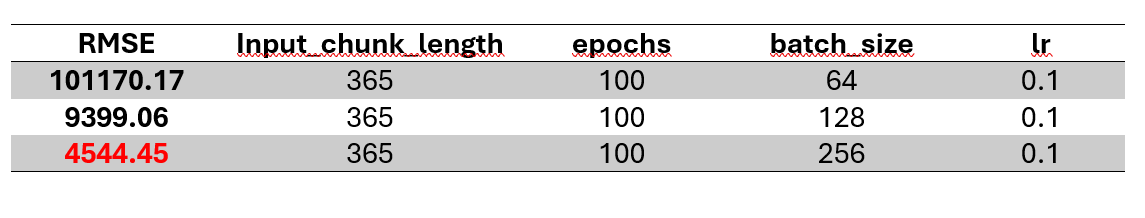



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE for Prague_1: 4544.45


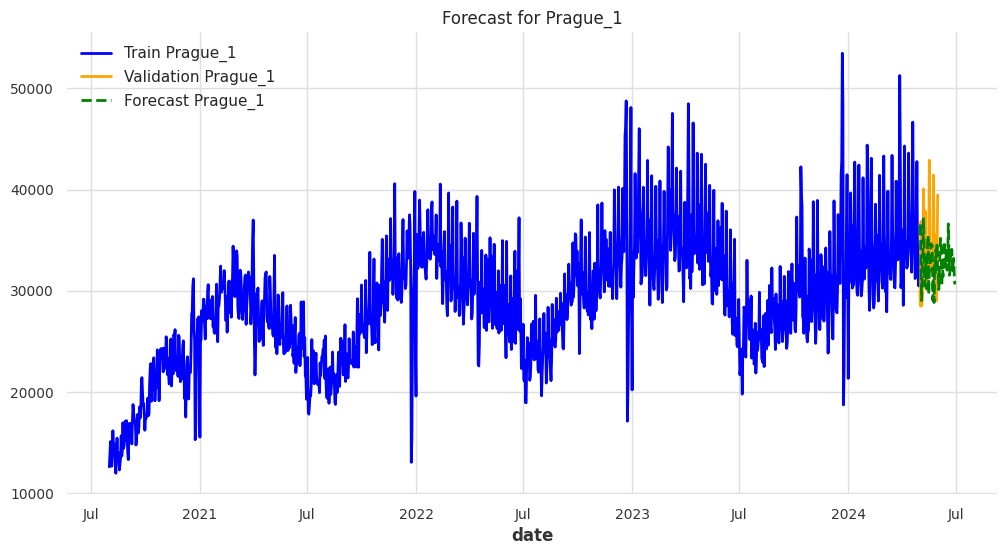

         date         sales
0  2024-05-01  35545.152907
1  2024-05-02  36741.293963
2  2024-05-03  31775.797439
3  2024-05-04  29031.067336
4  2024-05-05  32948.281740
5  2024-05-06  33355.178901
6  2024-05-07  37116.775634
7  2024-05-08  35257.910042
8  2024-05-09  30479.062171
9  2024-05-10  31250.225764
10 2024-05-11  33301.721005
11 2024-05-12  30207.106759
12 2024-05-13  31584.280096
13 2024-05-14  34206.565091
14 2024-05-15  35480.255104
15 2024-05-16  29667.512021
16 2024-05-17  31841.234150
17 2024-05-18  32141.058945
18 2024-05-19  33293.493355
19 2024-05-20  34647.320200
20 2024-05-21  34449.193342
21 2024-05-22  34474.744482
22 2024-05-23  29058.132871
23 2024-05-24  31974.573068
24 2024-05-25  28840.066938
25 2024-05-26  32574.940046
26 2024-05-27  31782.974735
27 2024-05-28  34050.550685
28 2024-05-29  33199.352637
29 2024-05-30  34748.663705
30 2024-05-31  31899.843103
31 2024-06-01  31992.760527
32 2024-06-02  30124.211075
33 2024-06-03  31893.945830
34 2024-06-04  33777

In [ ]:
Prague_1 = warehouse_data['Prague_1']
# Aplicar la función a cada una de las series y guardar las predicciones
forecast_Prague_1 = train_and_forecast(
    data=Prague_1,
    name="Prague_1",
    input_chunk_length=365,
    output_chunk_length=60,
    model_type="LSTM",
    random_state=42,
    n_epochs=100,
    batch_size=256,
    dropout=0.5,
    lr=0.1,
    activation="relu"
)

# Opcional: Puedes ver las predicciones de cada almacén
print(forecast_Prague_1)

##Warehouse Prague_2

In 2024, a growth in sales volume is observed compared to 2023. We continue to observe the patterns as peaks at the end of the year and beginning of the year, which may be due to the holidays. It is also observed that in the months of July and August, demand tends to decrease.

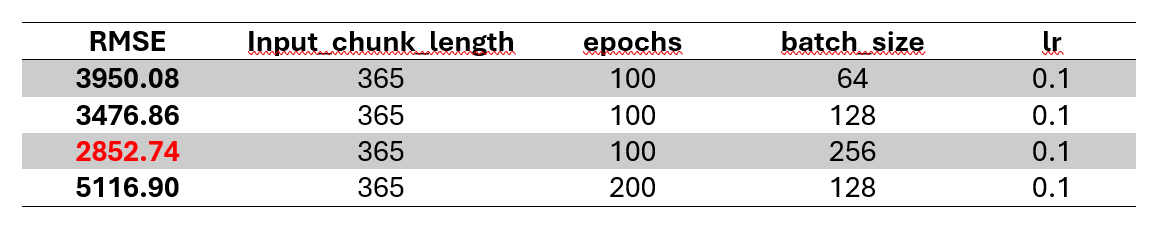

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE for Prague_2: 3476.86


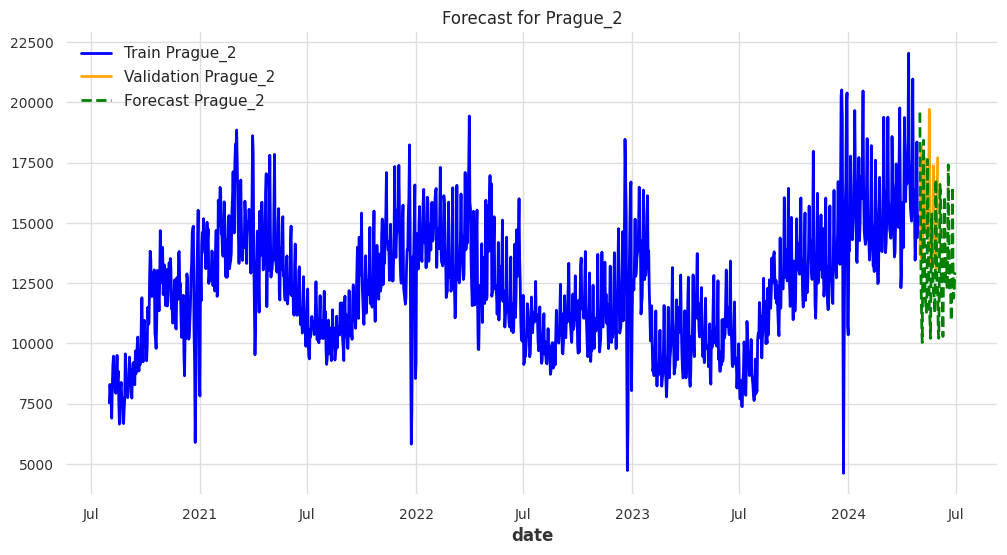

         date         sales
0  2024-05-01  19581.225701
1  2024-05-02  15535.673755
2  2024-05-03  12510.159695
3  2024-05-04  10987.632965
4  2024-05-05  10037.111512
5  2024-05-06  13703.491498
6  2024-05-07  18432.507330
7  2024-05-08  15379.798004
8  2024-05-09  13558.019228
9  2024-05-10  11935.009311
10 2024-05-11  11633.433492
11 2024-05-12  11291.043446
12 2024-05-13  11983.669907
13 2024-05-14  17630.025056
14 2024-05-15  14737.248963
15 2024-05-16  12986.927378
16 2024-05-17  11464.911886
17 2024-05-18  10955.354247
18 2024-05-19  10210.462228
19 2024-05-20  13342.277645
20 2024-05-21  15373.930589
21 2024-05-22  13519.520714
22 2024-05-23  12610.039830
23 2024-05-24  12124.303784
24 2024-05-25  12045.921912
25 2024-05-26  11283.735439
26 2024-05-27  12910.773076
27 2024-05-28  16799.373314
28 2024-05-29  14013.116292
29 2024-05-30  12309.828404
30 2024-05-31  12243.970303
31 2024-06-01  10507.877300
32 2024-06-02  10211.607885
33 2024-06-03  13276.885907
34 2024-06-04  16598

In [ ]:
Prague_2 = warehouse_data['Prague_2']
# Aplicar la función a cada una de las series y guardar las predicciones
forecast_Prague_2 = train_and_forecast(
    data=Prague_2,
    name="Prague_2",
    input_chunk_length=365,
    output_chunk_length=60,
    model_type="LSTM",
    random_state=42,
    n_epochs=100,
    batch_size=128,
    dropout=0.5,
    lr=0.1,
    activation="relu"
)

# Opcional: Puedes ver las predicciones de cada almacén
print(forecast_Prague_2)

##Warehouse Prague_3

Similar behavior to previous series

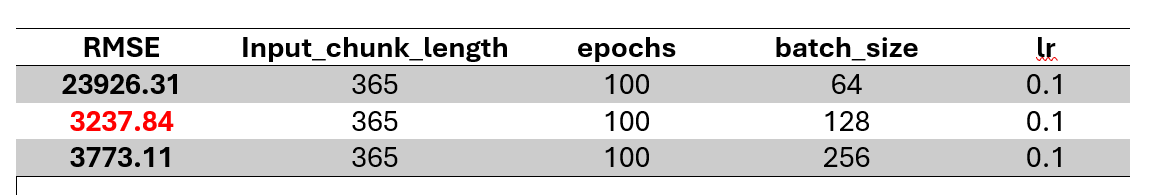

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE for Prague_3: 3773.11


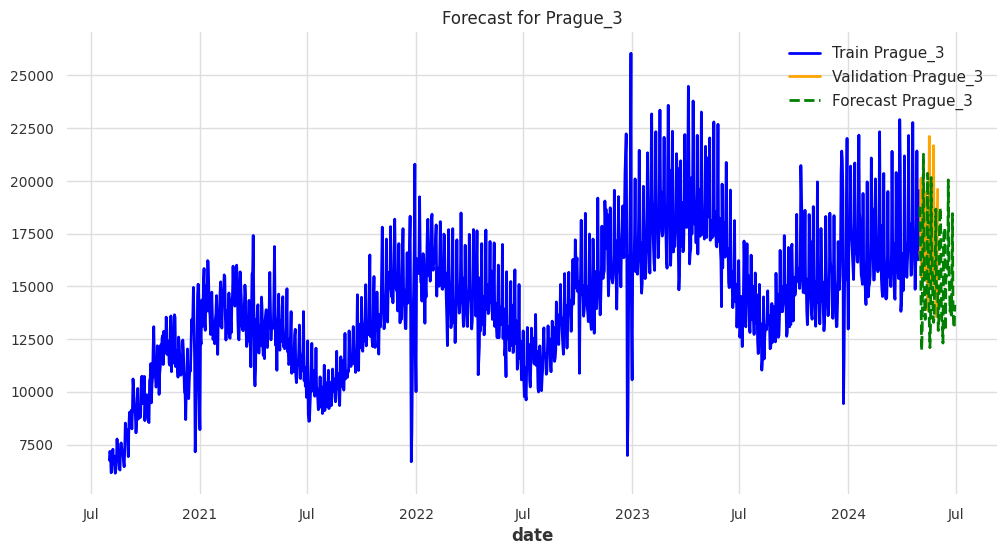

         date         sales
0  2024-05-01  18771.263866
1  2024-05-02  17035.445317
2  2024-05-03  14301.676472
3  2024-05-04  11974.354072
4  2024-05-05  13020.639127
5  2024-05-06  18173.961728
6  2024-05-07  21265.529885
7  2024-05-08  17450.815226
8  2024-05-09  14294.244330
9  2024-05-10  13435.423484
10 2024-05-11  14472.702992
11 2024-05-12  14472.904528
12 2024-05-13  14563.082145
13 2024-05-14  20360.089236
14 2024-05-15  17666.789713
15 2024-05-16  14721.251711
16 2024-05-17  13209.744167
17 2024-05-18  12095.339028
18 2024-05-19  13159.682862
19 2024-05-20  20159.400554
20 2024-05-21  17008.663534
21 2024-05-22  16044.621162
22 2024-05-23  14058.511948
23 2024-05-24  13294.887791
24 2024-05-25  13468.990000
25 2024-05-26  15208.271683
26 2024-05-27  16084.567892
27 2024-05-28  18667.107903
28 2024-05-29  14920.004686
29 2024-05-30  14969.091936
30 2024-05-31  14896.686523
31 2024-06-01  12908.442974
32 2024-06-02  13454.703665
33 2024-06-03  17460.246278
34 2024-06-04  18731

In [ ]:
Prague_3 = warehouse_data['Prague_3']
# Aplicar la función a cada una de las series y guardar las predicciones
forecast_Prague_3 = train_and_forecast(
    data=Prague_3,
    name="Prague_3",
    input_chunk_length=365,
    output_chunk_length=60,
    model_type="LSTM",
    random_state=42,
    n_epochs=100,
    batch_size=256,
    dropout=0.5,
    lr=0.1,
    activation="relu"
)

# Opcional: Puedes ver las predicciones de cada almacén
print(forecast_Prague_3)

##Warehouse Budapest_1

Similar behavior to previous series, but with more peaks
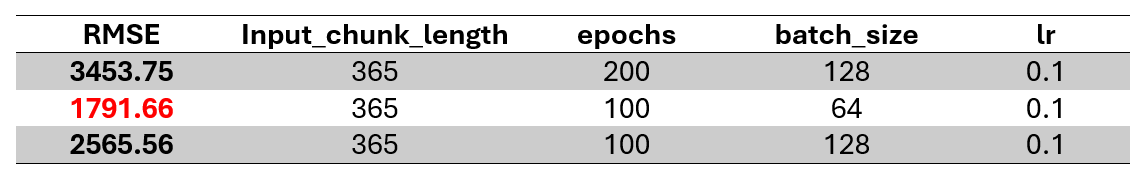

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE for Budapest_1: 2565.56


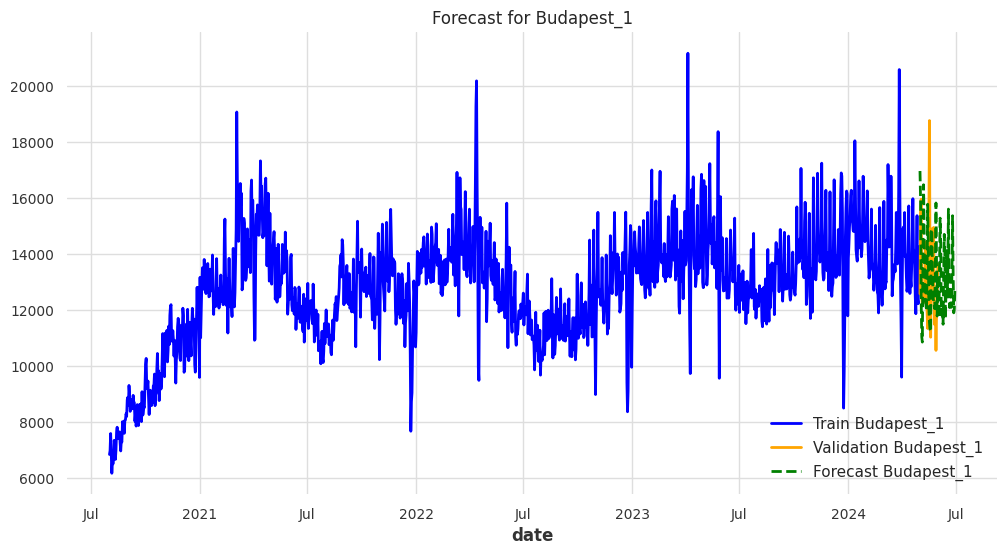

         date         sales
0  2024-05-01  16970.345956
1  2024-05-02  15925.687341
2  2024-05-03  12326.184349
3  2024-05-04  11050.392452
4  2024-05-05  10864.049507
5  2024-05-06  13947.776249
6  2024-05-07  16480.452890
7  2024-05-08  14874.548260
8  2024-05-09  13162.354110
9  2024-05-10  12341.153230
10 2024-05-11  12198.162970
11 2024-05-12  11978.345900
12 2024-05-13  13294.085836
13 2024-05-14  15786.550330
14 2024-05-15  14104.133426
15 2024-05-16  12089.839349
16 2024-05-17  11560.117848
17 2024-05-18  11307.030573
18 2024-05-19  11229.515335
19 2024-05-20  14823.680212
20 2024-05-21  14901.337873
21 2024-05-22  13581.047235
22 2024-05-23  12454.592680
23 2024-05-24  12337.056702
24 2024-05-25  12160.038463
25 2024-05-26  12057.486140
26 2024-05-27  13665.668784
27 2024-05-28  15828.783080
28 2024-05-29  13555.371642
29 2024-05-30  11793.470899
30 2024-05-31  13016.805250
31 2024-06-01  12052.989308
32 2024-06-02  11726.498513
33 2024-06-03  13634.126267
34 2024-06-04  15288

In [ ]:
Budapest_1 = warehouse_data['Budapest_1']
# Aplicar la función a cada una de las series y guardar las predicciones
forecast_Budapest_1 = train_and_forecast(
    data=Budapest_1,
    name="Budapest_1",
    input_chunk_length=365,
    output_chunk_length=60,
    model_type="LSTM",
    random_state=42,
    n_epochs=100,
    batch_size=128,
    dropout=0.5,
    lr=0.1,
    activation="relu"
)

# Opcional: Puedes ver las predicciones de cada almacén
print(forecast_Budapest_1)

##Warehouse Frankfurt_1

Frankfurt does not show the same behaviour as in the previous series. Many more peaks are observed, which are almost constant but with an increasing trend in sales volume.

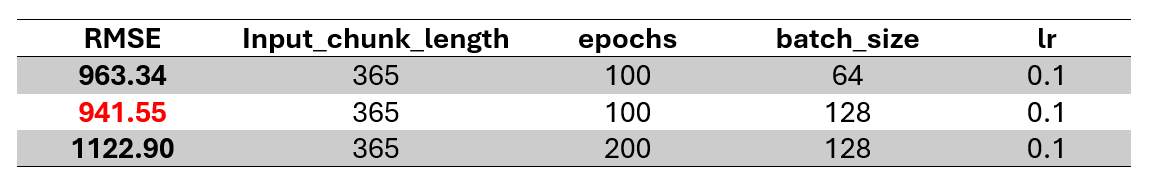


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE for Frankfurt_1: 941.55


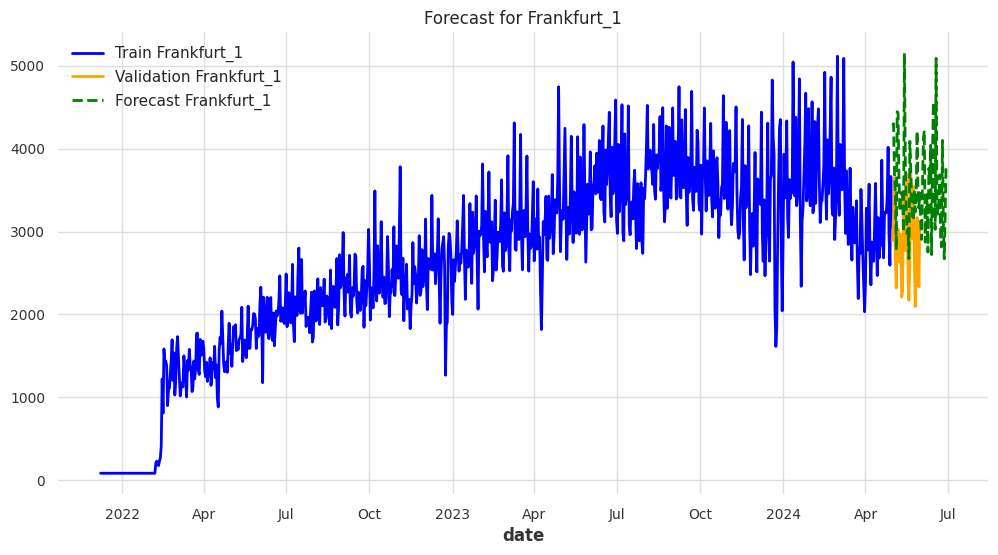

         date        sales
0  2024-05-01  4279.822726
1  2024-05-02  4300.705738
2  2024-05-03  3706.017254
3  2024-05-04  3484.703823
4  2024-05-05  2777.494194
5  2024-05-06  4445.738233
6  2024-05-07  4428.654283
7  2024-05-08  3663.825236
8  2024-05-09  3244.665359
9  2024-05-10  3422.919133
10 2024-05-11  3470.325719
11 2024-05-12  3414.934024
12 2024-05-13  2994.066201
13 2024-05-14  5150.897209
14 2024-05-15  3863.408210
15 2024-05-16  3266.310101
16 2024-05-17  2973.852697
17 2024-05-18  3026.966792
18 2024-05-19  2673.077923
19 2024-05-20  4087.722503
20 2024-05-21  3767.331049
21 2024-05-22  3367.245573
22 2024-05-23  3168.997328
23 2024-05-24  3134.858097
24 2024-05-25  3499.785327
25 2024-05-26  3235.529699
26 2024-05-27  3413.618507
27 2024-05-28  4208.515138
28 2024-05-29  3509.962425
29 2024-05-30  3284.588298
30 2024-05-31  3466.068039
31 2024-06-01  3115.362050
32 2024-06-02  2905.127426
33 2024-06-03  3593.326403
34 2024-06-04  4121.809674
35 2024-06-05  4217.448769
3

In [ ]:
Frankfurt_1 = warehouse_data['Frankfurt_1']
# Aplicar la función a cada una de las series y guardar las predicciones
forecast_Frankfurt_1= train_and_forecast(
    data=Frankfurt_1,
    name="Frankfurt_1",
    input_chunk_length=365,
    output_chunk_length=60,
    model_type="LSTM",
    random_state=42,
    n_epochs=100,
    batch_size=128,
    dropout=0.5,
    lr=0.1,
    activation="relu"
)

# Opcional: Puedes ver las predicciones de cada almacén
print(forecast_Frankfurt_1)

##Warehouse Munich_1

A general upward trend is observed with marked seasonal fluctuations, especially with peaks at certain periods of the year, suggesting recurring demand patterns.

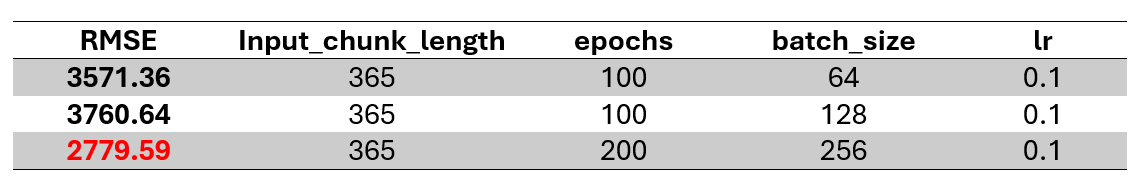

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE for Munich_1: 2779.59


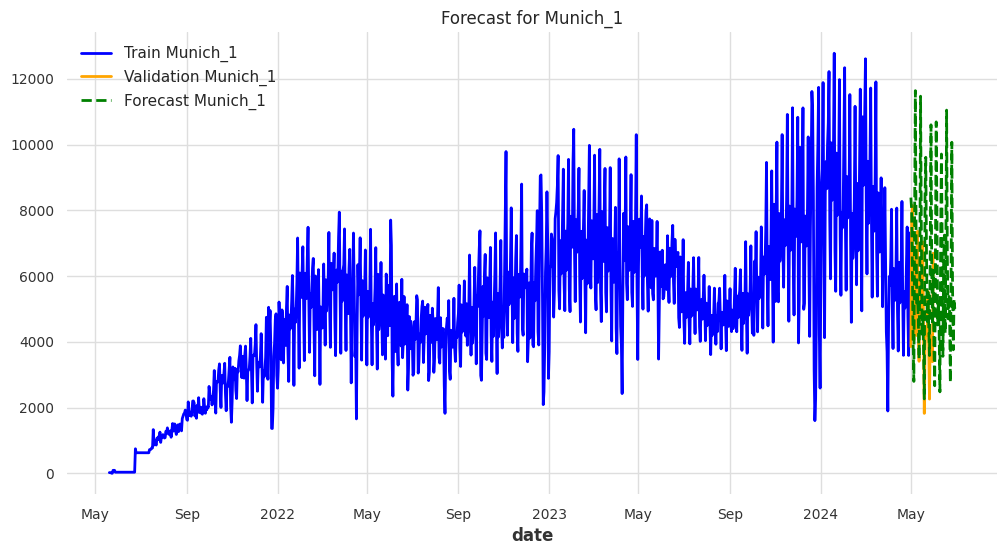

         date         sales
0  2024-05-01   8385.505830
1  2024-05-02   8022.331883
2  2024-05-03   6111.894175
3  2024-05-04   3971.742380
4  2024-05-05   2793.567264
5  2024-05-06   7850.177023
6  2024-05-07  11639.004629
7  2024-05-08   7198.089914
8  2024-05-09   5085.539850
9  2024-05-10   5373.959702
10 2024-05-11   4631.769618
11 2024-05-12   3482.552685
12 2024-05-13   6220.138845
13 2024-05-14  11470.793492
14 2024-05-15   7594.765093
15 2024-05-16   4155.471330
16 2024-05-17   4724.693707
17 2024-05-18   3790.756013
18 2024-05-19   2261.251999
19 2024-05-20   8434.667182
20 2024-05-21   9612.193133
21 2024-05-22   6594.734151
22 2024-05-23   4614.472207
23 2024-05-24   5508.879832
24 2024-05-25   4430.389579
25 2024-05-26   3581.181568
26 2024-05-27   6824.035628
27 2024-05-28  10600.217017
28 2024-05-29   6278.792348
29 2024-05-30   4511.853674
30 2024-05-31   6171.837107
31 2024-06-01   3804.546365
32 2024-06-02   2661.426094
33 2024-06-03   6836.171689
34 2024-06-04  10689

In [ ]:
Munich_1 = warehouse_data['Munich_1']
# Aplicar la función a cada una de las series y guardar las predicciones
forecast_Munich_1= train_and_forecast(
    data= Munich_1,
    name="Munich_1",
    input_chunk_length=365,
    output_chunk_length=60,
    model_type="LSTM",
    random_state=42,
    n_epochs=100,
    batch_size=256,
    dropout=0.5,
    lr=0.1,
    activation="relu"
)

# Opcional: Puedes ver las predicciones de cada almacén
print(forecast_Munich_1)

# BlockRNNModel Warehouse-Product

Dictionary to store processed data for each warehouse and product

In [41]:
# List of warehouse names
warehouses_product = ['Prague_1', 'Prague_3', 'Prague_2', 'Budapest_1', 'Frankfurt_1', 'Munich_1']

# Dictionary to store processed data for each warehouse
warehouse_data_product = {}

# Filter, select, and group data for each warehouse
for warehouse in warehouses_product:
    # Filter data for the current warehouse
    warehouse_df_product = final_combined_data[final_combined_data['warehouse'] == warehouse]

    # Select necessary columns and group by 'name' (product) and 'date'
    warehouse_data_product[warehouse] = (
        warehouse_df_product[['name', 'date', 'sales']]
        .groupby(['name', 'date'], as_index=False)['sales']
        .sum()
    )



##Prague_1

In [42]:
# Access the processed data for each warehouse
Prague_1_Product = warehouse_data_product['Prague_1']
print(Prague_1_Product.head(6))

unique_product_names = Prague_1_Product['name'].unique()
print(unique_product_names)


        name       date   sales
0  Apple_119 2021-11-15  171.38
1  Apple_119 2021-11-16  223.95
2  Apple_119 2021-11-17  223.95
3  Apple_119 2021-11-18  249.11
4  Apple_119 2021-11-19  262.68
5  Apple_119 2021-11-20  262.68
['Apple_119' 'Apple_19' 'Apple_69' 'Apple_96' 'Apricot_13' 'Avocado_14'
 'Avocado_2' 'Avocado_3' 'Bag_0' 'Bagel_6' 'Bagel_8' 'Baguette_3'
 'Baguette_6' 'Baguette_7' 'Banana_10' 'Basil_2' 'Basil_4' 'Beef_10'
 'Beef_17' 'Beef_5' 'Beef_9' 'Beet_5' 'Bell Pepper_11' 'Bell Pepper_16'
 'Bell Pepper_19' 'Bell Pepper_5' 'Berry_9' 'Blueberry_14' 'Bread_102'
 'Bread_103' 'Bread_143' 'Bread_153' 'Bread_165' 'Bread_171' 'Bread_181'
 'Bread_197' 'Bread_2' 'Bread_200' 'Bread_213' 'Bread_41' 'Bread_56'
 'Bread_69' 'Bread_76' 'Bread_78' 'Broccoli_2' 'Cabbage_1' 'Cabbage_12'
 'Cabbage_21' 'Carrot_17' 'Carrot_20' 'Carrot_21' 'Carrot_36' 'Celery_13'
 'Celery_16' 'Chicken_11' 'Chicken_25' 'Chicken_31' 'Chicken_41'
 'Chicken_43' 'Chicken_51' 'Chicken_62' 'Chicken_66' 'Chicken_73'
 'Chick

###Prague_1_forecast_Bread_165

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | Metri

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE for Prague_1_Bread_165: 92.34


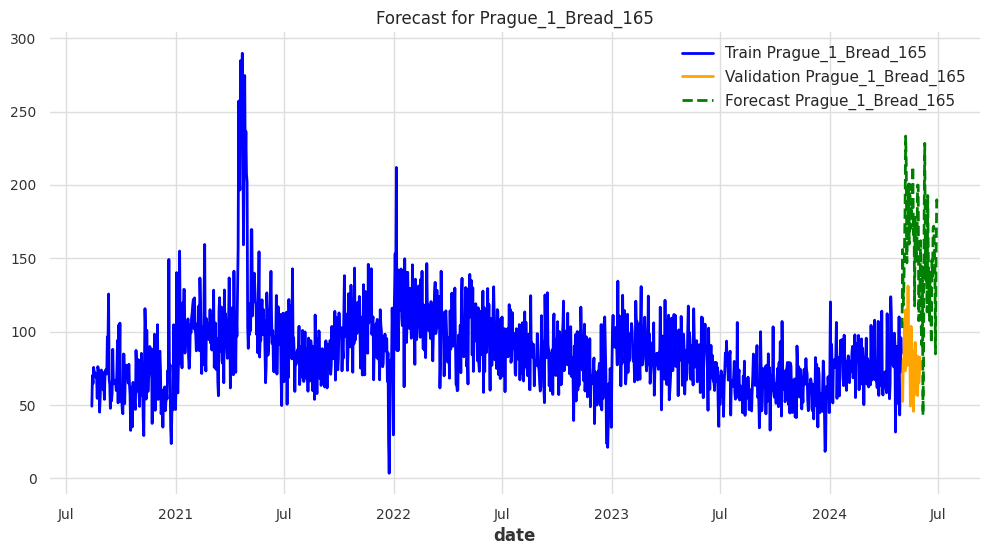

         date       sales
0  2024-05-01  102.379671
1  2024-05-02  155.958281
2  2024-05-03  117.957356
3  2024-05-04  131.237490
4  2024-05-05  156.288909
5  2024-05-06  182.108182
6  2024-05-07  233.288087
7  2024-05-08  214.444269
8  2024-05-09  146.820928
9  2024-05-10  177.213597
10 2024-05-11  174.681561
11 2024-05-12  200.677367
12 2024-05-13  159.662949
13 2024-05-14  200.375314
14 2024-05-15  169.909229
15 2024-05-16  190.157963
16 2024-05-17  181.203540
17 2024-05-18  178.509759
18 2024-05-19  212.474315
19 2024-05-20  166.109911
20 2024-05-21  179.747834
21 2024-05-22  117.471326
22 2024-05-23  177.809141
23 2024-05-24  154.768823
24 2024-05-25  148.003799
25 2024-05-26  161.120199
26 2024-05-27  199.866793
27 2024-05-28  199.765949
28 2024-05-29  107.448912
29 2024-05-30  131.829029
30 2024-05-31  130.104989
31 2024-06-01  161.950016
32 2024-06-02  103.738885
33 2024-06-03   90.805152
34 2024-06-04  144.270982
35 2024-06-05   43.057802
36 2024-06-06   81.690302
37 2024-06-0

In [57]:
Prague_1_Bread_165 = Prague_1_Product[Prague_1_Product['name'] == 'Bread_165']
forecast_Bread_165 = train_and_forecast(
    data= Prague_1_Bread_165,
    name="Prague_1_Bread_165",
    input_chunk_length= 365,
    output_chunk_length=60,
    model_type="LSTM",
    random_state=42,
    n_epochs=200,
    batch_size=64,
    dropout=0.5,
    lr=0.1,
    activation="relu"
)

# Opcional: Puedes ver las predicciones de cada almacén
print(forecast_Bread_165)




###Prague_1_forecast_Chicken_51

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | Metri

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE for Prague_1_Chicken_51: 27.92


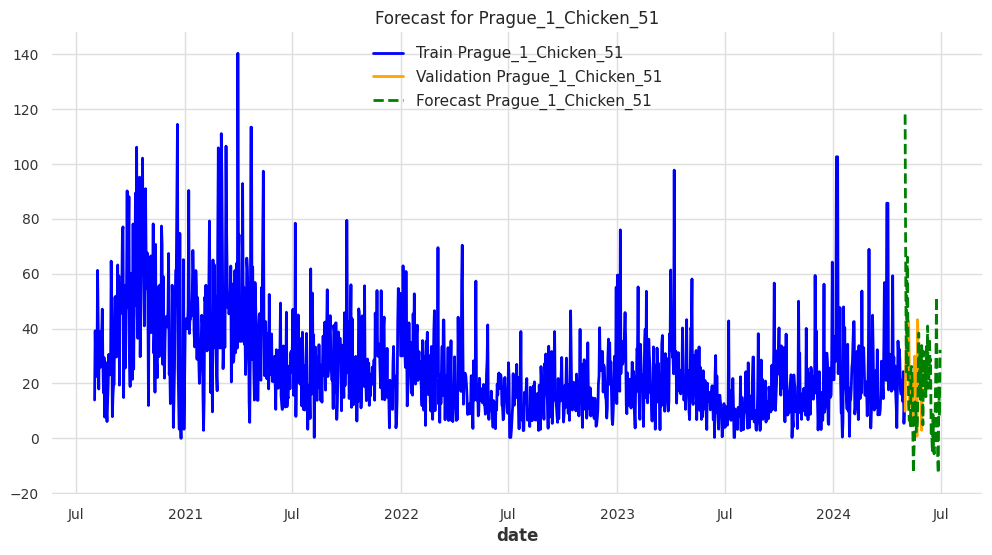

         date       sales
0  2024-05-01  118.034915
1  2024-05-02   62.522061
2  2024-05-03   24.281785
3  2024-05-04   59.688424
4  2024-05-05   66.057899
5  2024-05-06   28.208364
6  2024-05-07   11.764593
7  2024-05-08    6.582025
8  2024-05-09    8.785142
9  2024-05-10    4.572748
10 2024-05-11   25.436147
11 2024-05-12   26.231248
12 2024-05-13   20.069467
13 2024-05-14    3.604249
14 2024-05-15  -12.579984
15 2024-05-16   -3.928651
16 2024-05-17   -0.379632
17 2024-05-18   13.283278
18 2024-05-19    9.661687
19 2024-05-20    2.474266
20 2024-05-21    2.931094
21 2024-05-22    7.538158
22 2024-05-23   19.894875
23 2024-05-24   38.361571
24 2024-05-25   14.585034
25 2024-05-26   31.982489
26 2024-05-27   14.141859
27 2024-05-28   25.613532
28 2024-05-29   33.814326
29 2024-05-30   28.232202
30 2024-05-31    4.914553
31 2024-06-01   31.675254
32 2024-06-02   20.174717
33 2024-06-03   20.534744
34 2024-06-04   24.449644
35 2024-06-05   15.168650
36 2024-06-06   33.528182
37 2024-06-0

In [60]:
Prague_1_Chicken_51 = Prague_1_Product[Prague_1_Product['name'] == 'Chicken_51']
forecast_Chicken_51 = train_and_forecast(
    data= Prague_1_Chicken_51,
    name="Prague_1_Chicken_51",
    input_chunk_length=365,
    output_chunk_length=60,
    model_type="LSTM",
    random_state=42,
    n_epochs=200,
    batch_size=64,
    dropout=0.5,
    lr=0.1,
    activation="relu"
)

# Opcional: Puedes ver las predicciones de cada almacén
print(forecast_Chicken_51)


##Prague_2

In [62]:
# Access the processed data for each warehouse
Prague_2_Product = warehouse_data_product['Prague_2']
print(Prague_2_Product.head(6))

unique_product_names1 = Prague_2_Product['name'].unique()
print(unique_product_names1)

        name       date  sales
0  Apple_107 2021-02-01   9.00
1  Apple_107 2021-02-02   4.55
2  Apple_107 2021-02-03   4.48
3  Apple_107 2021-02-04   7.66
4  Apple_107 2021-02-05   2.25
5  Apple_107 2021-02-06  10.46
['Apple_107' 'Apple_132' 'Apple_43' 'Arugula_1' 'Arugula_5' 'Avocado_2'
 'Baguette_3' 'Baguette_31' 'Baguette_6' 'Banana_7' 'Beef_10' 'Beef_19'
 'Beef_28' 'Beef_5' 'Beef_9' 'Beet_0' 'Beet_5' 'Bell Pepper_16'
 'Bell Pepper_5' 'Blueberry_11' 'Blueberry_14' 'Bread_1' 'Bread_102'
 'Bread_104' 'Bread_137' 'Bread_141' 'Bread_153' 'Bread_160' 'Bread_165'
 'Bread_169' 'Bread_172' 'Bread_188' 'Bread_190' 'Bread_198' 'Bread_200'
 'Bread_43' 'Bread_56' 'Bread_62' 'Bread_69' 'Bread_70' 'Bread_97'
 'Breadcrumb_7' 'Bun_0' 'Cabbage_12' 'Cabbage_17' 'Cabbage_21'
 'Cactus Fruit_0' 'Carrot_17' 'Carrot_33' 'Carrot_9' 'Celery_13'
 'Cheese_0' 'Chicken_11' 'Chicken_13' 'Chicken_17' 'Chicken_21'
 'Chicken_29' 'Chicken_31' 'Chicken_38' 'Chicken_77' 'Chicken_78'
 'Chicken_90' 'Chicken_92' 'Chicken

###Prague_2_forecast_Beef_28

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | Metri

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE for Prague_2_Beef_28: 11.42


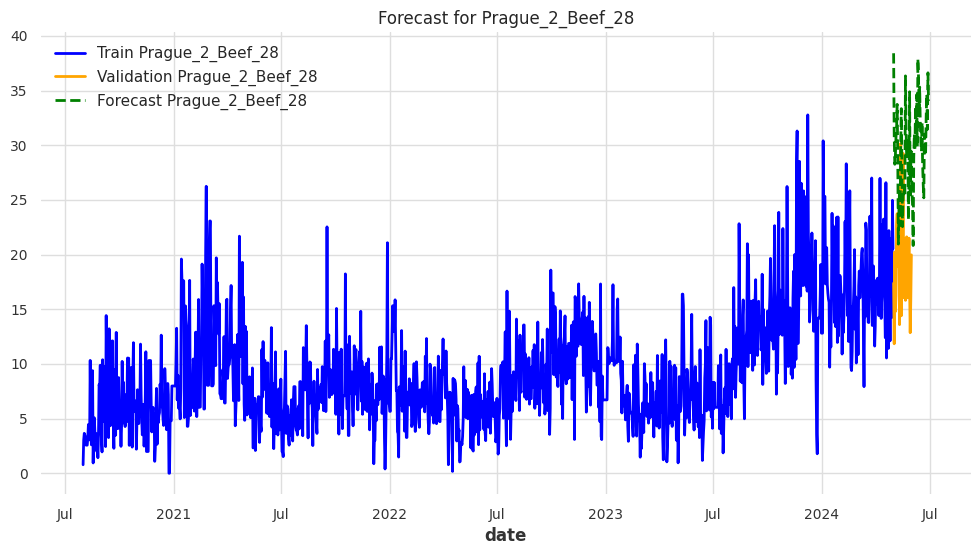

         date      sales
0  2024-05-01  38.407384
1  2024-05-02  30.845426
2  2024-05-03  28.254130
3  2024-05-04  29.062489
4  2024-05-05  30.725078
5  2024-05-06  31.459936
6  2024-05-07  33.733276
7  2024-05-08  28.890236
8  2024-05-09  20.954119
9  2024-05-10  24.118718
10 2024-05-11  25.965728
11 2024-05-12  22.643832
12 2024-05-13  30.185268
13 2024-05-14  33.342522
14 2024-05-15  28.269910
15 2024-05-16  22.548618
16 2024-05-17  25.336980
17 2024-05-18  25.632681
18 2024-05-19  26.344672
19 2024-05-20  25.319854
20 2024-05-21  36.337464
21 2024-05-22  31.652370
22 2024-05-23  28.953509
23 2024-05-24  29.875345
24 2024-05-25  30.378955
25 2024-05-26  23.176207
26 2024-05-27  27.386056
27 2024-05-28  34.883611
28 2024-05-29  25.152115
29 2024-05-30  28.244625
30 2024-05-31  29.415386
31 2024-06-01  25.948485
32 2024-06-02  24.466998
33 2024-06-03  20.824305
34 2024-06-04  28.835002
35 2024-06-05  31.008551
36 2024-06-06  29.657006
37 2024-06-07  33.560823
38 2024-06-08  30.342629


In [63]:
Prague_2_Beef_28 = Prague_2_Product[Prague_2_Product['name'] == 'Beef_28']
forecast_Beef_28 = train_and_forecast(
    data= Prague_2_Beef_28,
    name="Prague_2_Beef_28",
    input_chunk_length= 365,
    output_chunk_length=60,
    model_type="LSTM",
    random_state=42,
    n_epochs=100,
    batch_size=64,
    dropout=0.5,
    lr=0.1,
    activation="relu"
)

# Opcional: Puedes ver las predicciones de cada almacén
print(forecast_Beef_28)


###Prague_2_forecast_Croissant_9

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE for Prague_2_Croissant_9: 11.29


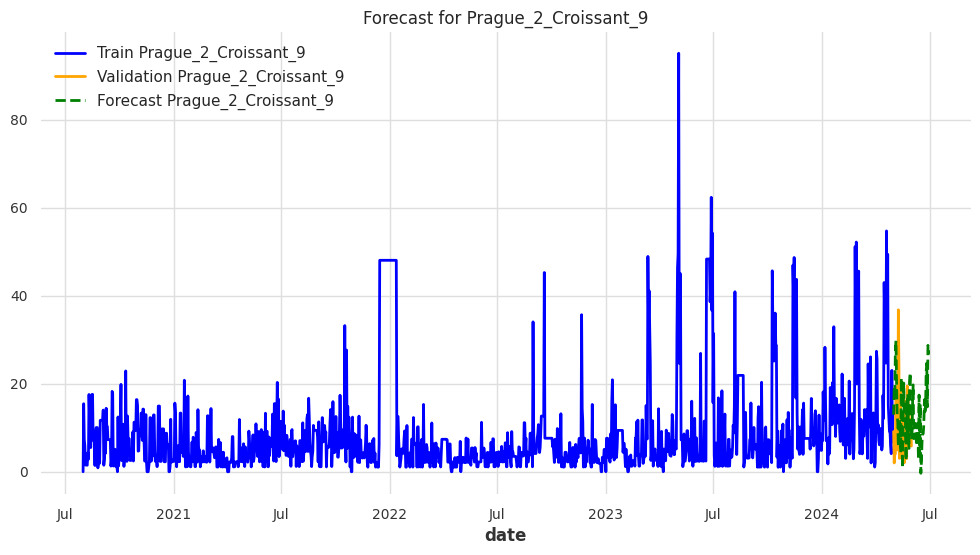

         date      sales
0  2024-05-01  12.947759
1  2024-05-02  19.324449
2  2024-05-03  16.525972
3  2024-05-04  27.983018
4  2024-05-05  29.765753
5  2024-05-06  20.076600
6  2024-05-07  12.876277
7  2024-05-08  11.259825
8  2024-05-09   5.716578
9  2024-05-10  11.140586
10 2024-05-11  11.398716
11 2024-05-12   9.845540
12 2024-05-13   4.383628
13 2024-05-14  21.311717
14 2024-05-15   9.301141
15 2024-05-16   0.882381
16 2024-05-17  12.531921
17 2024-05-18  20.153181
18 2024-05-19  13.881535
19 2024-05-20  12.867318
20 2024-05-21  11.064781
21 2024-05-22   2.569787
22 2024-05-23  16.211022
23 2024-05-24   8.568597
24 2024-05-25  17.638554
25 2024-05-26   7.700436
26 2024-05-27   5.286777
27 2024-05-28  20.265283
28 2024-05-29  22.451499
29 2024-05-30   8.798177
30 2024-05-31   9.814300
31 2024-06-01   7.288120
32 2024-06-02  15.430221
33 2024-06-03  19.726954
34 2024-06-04   7.525843
35 2024-06-05   8.677911
36 2024-06-06  11.017275
37 2024-06-07   9.976830
38 2024-06-08   7.477866


In [ ]:
Prague_2_Croissant_9 = Prague_2_Product[Prague_2_Product['name'] == 'Croissant_9']
forecast_Croissant_9 = train_and_forecast(
    data= Prague_2_Croissant_9,
    name="Prague_2_Croissant_9",
    input_chunk_length= 365,
    output_chunk_length=60,
    model_type="LSTM",
    random_state=42,
    n_epochs=100,
    batch_size=64,
    dropout=0.5,
    lr=0.1,
    activation="relu"
)

# Opcional: Puedes ver las predicciones de cada almacén
print(forecast_Croissant_9)

## Prague_3

In [64]:
# Access the processed data for each warehouse
Prague_3_Product = warehouse_data_product['Prague_3']
print(Prague_3_Product.head(6))

unique_product_names = Prague_3_Product['name'].unique()
print(unique_product_names)

       name       date  sales
0  Apple_19 2023-03-19  11.54
1  Apple_19 2023-03-20   9.41
2  Apple_19 2023-03-21   8.01
3  Apple_19 2023-03-22  19.84
4  Apple_19 2023-03-23  18.00
5  Apple_19 2023-03-24  10.10
['Apple_19' 'Apple_21' 'Apple_3' 'Apple_49' 'Arugula_1' 'Asparagus_13'
 'Asparagus_5' 'Baguette_0' 'Baguette_13' 'Baguette_15' 'Baguette_25'
 'Baguette_26' 'Baguette_40' 'Banana_10' 'Basil_2' 'Basil_5' 'Beef_13'
 'Beef_19' 'Beef_24' 'Beef_7' 'Beef_9' 'Beet_0' 'Bell Pepper_5'
 'Bell Pepper_9' 'Biscuit_0' 'Blueberry_14' 'Bread_102' 'Bread_129'
 'Bread_133' 'Bread_141' 'Bread_142' 'Bread_18' 'Bread_183' 'Bread_198'
 'Bread_200' 'Bread_201' 'Bread_203' 'Bread_41' 'Bread_50' 'Bread_54'
 'Bread_69' 'Bread_70' 'Broccoli_2' 'Cabbage_1' 'Cabbage_12' 'Cabbage_17'
 'Cabbage_4' 'Cabbage_6' 'Cabbage_7' 'Cake_5' 'Carrot_17' 'Carrot_33'
 'Cauliflower_2' 'Celery_16' 'Chicken_17' 'Chicken_21' 'Chicken_31'
 'Chicken_41' 'Chicken_42' 'Chicken_45' 'Chicken_61' 'Chicken_62'
 'Chicken_66' 'Chicken_68'

###Prague_3_forecast_Mix_meat_5

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | Metri

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE for Prague_3_Mix_meat_5: 59.77


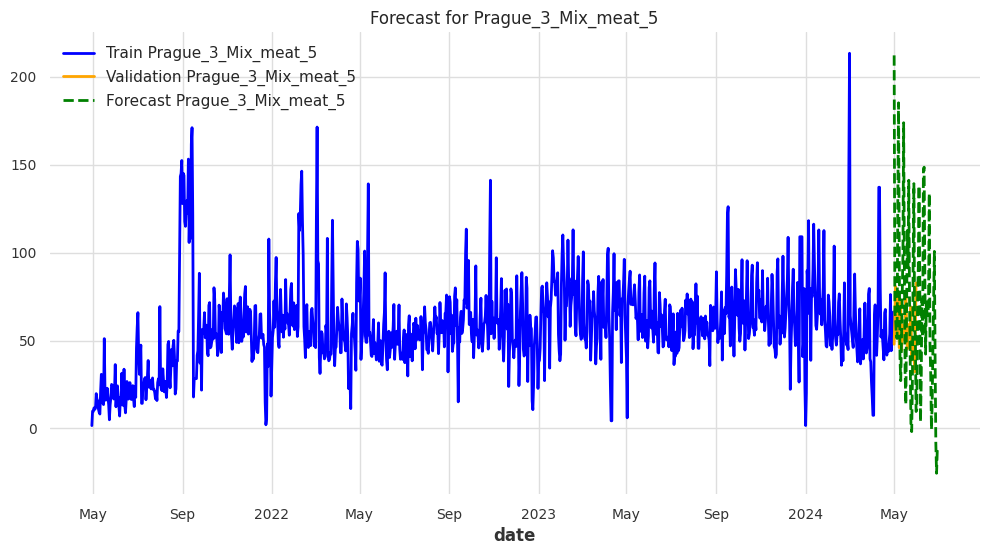

         date       sales
0  2024-05-01  212.058865
1  2024-05-02   66.633744
2  2024-05-03   62.116662
3  2024-05-04   52.869442
4  2024-05-05   51.158428
5  2024-05-06  128.552031
6  2024-05-07  185.096565
7  2024-05-08   97.280442
8  2024-05-09   39.581171
9  2024-05-10   27.171099
10 2024-05-11   48.436456
11 2024-05-12   75.012525
12 2024-05-13   98.604903
13 2024-05-14  173.780405
14 2024-05-15   89.578761
15 2024-05-16   31.524126
16 2024-05-17   13.638061
17 2024-05-18   67.013807
18 2024-05-19  112.524350
19 2024-05-20   91.193793
20 2024-05-21  141.082172
21 2024-05-22   74.067818
22 2024-05-23   37.472242
23 2024-05-24    1.249909
24 2024-05-25   -1.781123
25 2024-05-26   29.051317
26 2024-05-27   95.442146
27 2024-05-28  139.172806
28 2024-05-29   56.447508
29 2024-05-30   51.398094
30 2024-05-31    9.648448
31 2024-06-01   11.000033
32 2024-06-02   71.620834
33 2024-06-03   91.181694
34 2024-06-04  138.051865
35 2024-06-05   87.613209
36 2024-06-06    3.698103
37 2024-06-0

In [68]:
Prague_3_Mix_meat_5 = Prague_3_Product[Prague_3_Product['name'] == 'Mix meat_5']
forecast_Mix_meat_5 = train_and_forecast(
    data= Prague_3_Mix_meat_5,
    name="Prague_3_Mix_meat_5",
    input_chunk_length= 365,
    output_chunk_length=60,
    model_type="LSTM",
    random_state=42,
    n_epochs=200,
    batch_size=256,
    dropout=0.5,
    lr=0.1,
    activation="relu"
)

# Opcional: Puedes ver las predicciones de cada almacén
print(forecast_Mix_meat_5)

###Prague_3_forecast_Chicken_77

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | Metri

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE for Prague_3_Chicken_77: 53.31


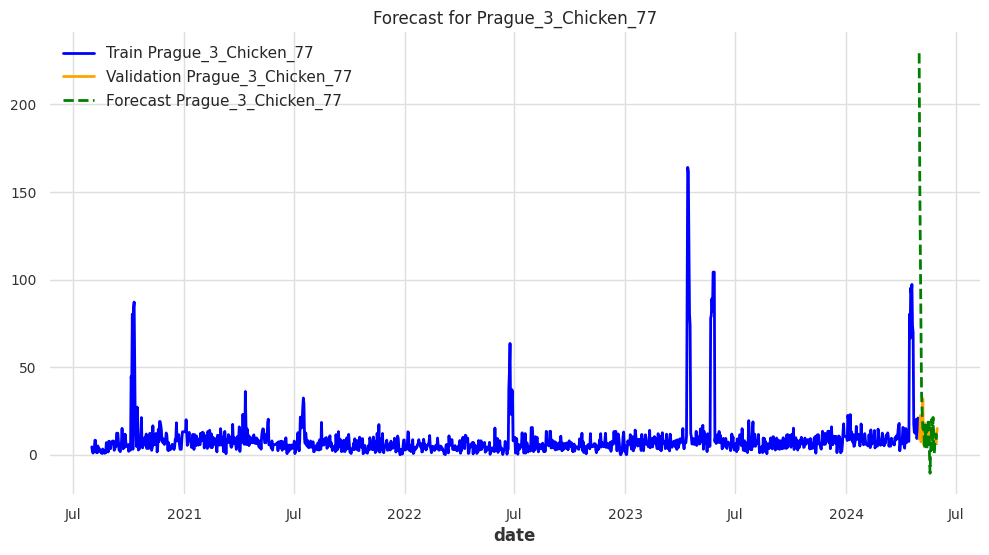

         date       sales
0  2024-05-01  229.225938
1  2024-05-02  157.152841
2  2024-05-03  114.533518
3  2024-05-04   71.881378
4  2024-05-05   34.135214
5  2024-05-06   23.918891
6  2024-05-07   15.119019
7  2024-05-08   14.993497
8  2024-05-09   10.585036
9  2024-05-10    3.350261
10 2024-05-11   17.015515
11 2024-05-12    4.988685
12 2024-05-13   15.842961
13 2024-05-14    3.071703
14 2024-05-15   16.667040
15 2024-05-16   18.792577
16 2024-05-17   20.511487
17 2024-05-18    1.133905
18 2024-05-19  -10.539706
19 2024-05-20    2.881439
20 2024-05-21    7.412582
21 2024-05-22   20.315269
22 2024-05-23    3.019711
23 2024-05-24   21.332901
24 2024-05-25    4.738363
25 2024-05-26    0.521796
26 2024-05-27    6.951670
27 2024-05-28    9.170197
28 2024-05-29   11.874421
29 2024-05-30    5.785183


In [86]:
Prague_3_Chicken_77 = Prague_3_Product[Prague_3_Product['name'] == 'Chicken_77']
forecast_Chicken_77 = train_and_forecast(
    data= Prague_3_Chicken_77,
    name="Prague_3_Chicken_77",
    input_chunk_length= 365,
    output_chunk_length=30,
    model_type="LSTM",
    random_state=42,
    n_epochs=100,
    batch_size=128,
    dropout=0.5,
    lr=0.1,
    activation="relu"
)

# Opcional: Puedes ver las predicciones de cada almacén
print(forecast_Chicken_77)

## Budapest_1




In [87]:
# Access the processed data for each warehouse
Budapest_1_Product = warehouse_data_product['Budapest_1']
print(Budapest_1_Product.head(6))

unique_product_names = Budapest_1_Product['name'].unique()
print(unique_product_names)

        name       date   sales
0  Apple_109 2020-09-29  205.69
1  Apple_109 2020-09-30  296.88
2  Apple_109 2020-10-01  405.39
3  Apple_109 2020-10-02  456.83
4  Apple_109 2020-10-03  450.06
5  Apple_109 2020-10-04  336.16
['Apple_109' 'Apple_7' 'Apple_95' 'Apricot_11' 'Arugula_9' 'Avocado_12'
 'Avocado_15' 'Avocado_6' 'Bagel_1' 'Bagel_7' 'Baguette_4' 'Baguette_9'
 'Banana_1' 'Banana_2' 'Banana_6' 'Beet_7' 'Bell Pepper_4' 'Biscuit_1'
 'Bread_106' 'Bread_111' 'Bread_112' 'Bread_148' 'Bread_154' 'Bread_157'
 'Bread_163' 'Bread_170' 'Bread_189' 'Bread_221' 'Bread_230' 'Bread_24'
 'Bread_35' 'Bread_44' 'Bread_52' 'Bread_57' 'Bread_63' 'Bread_67'
 'Bread_86' 'Bread_99' 'Breadcrumb_6' 'Cabbage_19' 'Cabbage_9'
 'Cantaloupe_2' 'Carrot_30' 'Carrot_34' 'Carrot_5' 'Cauliflower_0'
 'Celeriac_0' 'Chicken_100' 'Chicken_16' 'Chicken_28' 'Chicken_47'
 'Chicken_48' 'Chicken_50' 'Chicken_52' 'Chive_0' 'Chive_2' 'Croissant_0'
 'Croissant_2' 'Croissant_24' 'Croissant_3' 'Croissant_31' 'Croissant_35'
 'Cu

###Budapest_1_forecast_Pork_34

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE for Budapest_1_Pork_34: 13.02


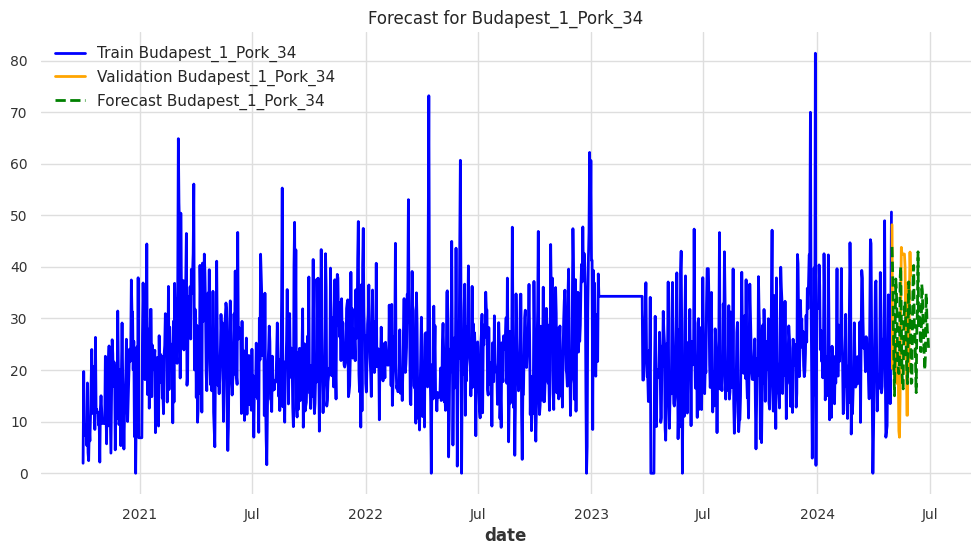

         date      sales
0  2024-05-01  43.872639
1  2024-05-02  38.901839
2  2024-05-03  29.597642
3  2024-05-04  20.801886
4  2024-05-05  15.014028
5  2024-05-06  27.722371
6  2024-05-07  37.667923
7  2024-05-08  35.453322
8  2024-05-09  30.887710
9  2024-05-10  21.912793
10 2024-05-11  20.545653
11 2024-05-12  19.322370
12 2024-05-13  22.272059
13 2024-05-14  37.780724
14 2024-05-15  40.019568
15 2024-05-16  30.018079
16 2024-05-17  19.672337
17 2024-05-18  17.562278
18 2024-05-19  16.342781
19 2024-05-20  29.289513
20 2024-05-21  32.057627
21 2024-05-22  33.305032
22 2024-05-23  30.035197
23 2024-05-24  22.857423
24 2024-05-25  19.490475
25 2024-05-26  17.366191
26 2024-05-27  28.551058
27 2024-05-28  37.098443
28 2024-05-29  33.351595
29 2024-05-30  29.455103
30 2024-05-31  26.051876
31 2024-06-01  17.420522
32 2024-06-02  17.644892
33 2024-06-03  29.222565
34 2024-06-04  37.909510
35 2024-06-05  40.283446
36 2024-06-06  27.807552
37 2024-06-07  26.884324
38 2024-06-08  21.367629


In [ ]:
Budapest_1_Pork_34 = Budapest_1_Product[Budapest_1_Product['name'] == 'Pork_34']
forecast_Pork_34 = train_and_forecast(
    data= Budapest_1_Pork_34,
    name="Budapest_1_Pork_34",
    input_chunk_length= 365,
    output_chunk_length=60,
    model_type="LSTM",
    random_state=42,
    n_epochs=100,
    batch_size=128,
    dropout=0.5,
    lr=0.1,
    activation="relu"
)

# Opcional: Puedes ver las predicciones de cada almacén
print(forecast_Pork_34)

###Budapest_1_forecast_Potato_10

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE for Budapest_1_Potato_10: 295.87


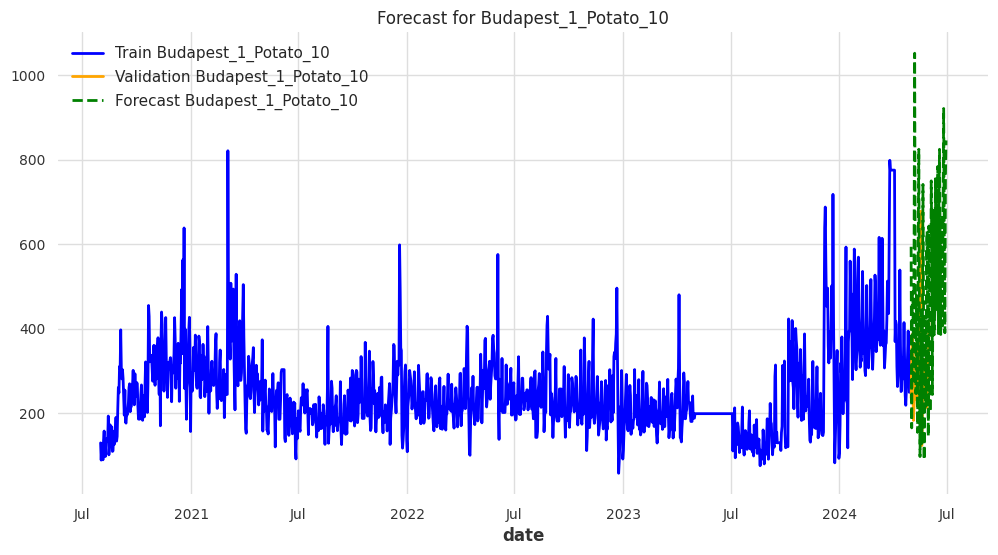

         date        sales
0  2024-05-01   593.761014
1  2024-05-02   164.840913
2  2024-05-03   474.755971
3  2024-05-04   487.175846
4  2024-05-05   268.349001
5  2024-05-06   592.689814
6  2024-05-07  1052.039866
7  2024-05-08   471.801983
8  2024-05-09   246.230965
9  2024-05-10   479.046074
10 2024-05-11   297.759395
11 2024-05-12   154.178215
12 2024-05-13   608.321135
13 2024-05-14   824.654963
14 2024-05-15   418.745535
15 2024-05-16    97.018603
16 2024-05-17   221.569358
17 2024-05-18   443.360877
18 2024-05-19   127.654599
19 2024-05-20   334.365646
20 2024-05-21   741.449206
21 2024-05-22   449.634553
22 2024-05-23    89.427024
23 2024-05-24   418.689826
24 2024-05-25   252.396317
25 2024-05-26   215.706428
26 2024-05-27   583.398784
27 2024-05-28   630.497283
28 2024-05-29   380.006210
29 2024-05-30   144.560539
30 2024-05-31   642.887393
31 2024-06-01   544.754360
32 2024-06-02   202.292749
33 2024-06-03   432.844657
34 2024-06-04   749.812440
35 2024-06-05   572.455118
3

In [ ]:
Budapest_1_Potato_10 = Budapest_1_Product[Budapest_1_Product['name'] == 'Potato_10']
forecast_Potato_10 = train_and_forecast(
    data= Budapest_1_Potato_10,
    name="Budapest_1_Potato_10",
    input_chunk_length= 365,
    output_chunk_length=60,
    model_type="LSTM",
    random_state=42,
    n_epochs=100,
    batch_size=128,
    dropout=0.5,
    lr=0.1,
    activation="relu"
)

# Opcional: Puedes ver las predicciones de cada almacén
print(forecast_Potato_10)

## Frankfurt_1

In [ ]:
# Access the processed data for each warehouse
Frankfurt_1_Product = warehouse_data_product['Frankfurt_1']
print(Frankfurt_1_Product.head(6))

unique_product_names = Frankfurt_1_Product['name'].unique()
print(unique_product_names)

        name       date  sales
0  Apple_124 2022-02-08  11.44
1  Apple_124 2022-02-09  11.44
2  Apple_124 2022-02-10  10.26
3  Apple_124 2022-02-11  10.26
4  Apple_124 2022-02-12  10.26
5  Apple_124 2022-02-13  10.26
['Apple_124' 'Apple_29' 'Apple_42' 'Arugula_10' 'Asparagus_0' 'Avocado_5'
 'Bag_1' 'Bagel_4' 'Bakery_0' 'Banana_0' 'Beef_22' 'Bread_109' 'Bread_184'
 'Bread_39' 'Bread_58' 'Bread_79' 'Bread_8' 'Bread_88' 'Chestnut_0'
 'Chicory_1' 'Clementine_3' 'Corn_0' 'Corn_1' 'Croissant_5' 'Cucumber_23'
 'Cucumber_33' 'Donut_7' 'Eggplant_6' 'Grapefruit_2' 'Herb_5' 'Herb_6'
 'Kohlrabi_12' 'Lemon_10' 'Lettuce_2' 'Lettuce_8' 'Mint_2' 'Mushroom_9'
 'Nectarine_1' 'Pastry_157' 'Pastry_160' 'Pastry_172' 'Pastry_198'
 'Pastry_21' 'Pear_29' 'Pear_5' 'Pepper_12' 'Pepper_20' 'Pizza_0'
 'Pretzel_10' 'Pretzel_4' 'Pretzel_8' 'Roll_21' 'Salad_54' 'Salmon_11'
 'Salmon_12' 'Shrimp_1' 'Tomato_19' 'Tomato_67' 'Tomato_71']


###Frankfurt_1_forecast_Beef_22

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE for Frankfurt_1_Beef_22: 31.09


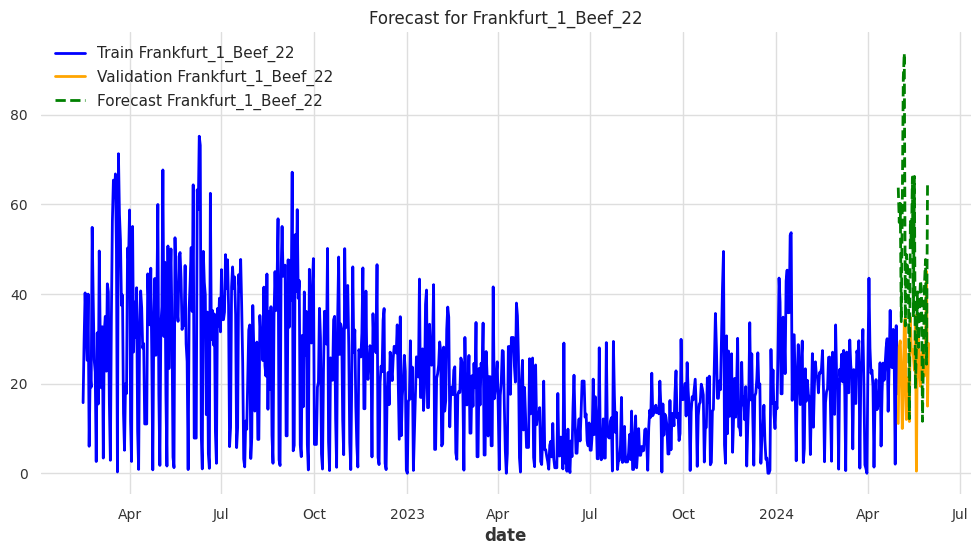

         date      sales
0  2024-05-01  63.735132
1  2024-05-02  55.968403
2  2024-05-03  60.225282
3  2024-05-04  33.823750
4  2024-05-05  60.218298
5  2024-05-06  88.310354
6  2024-05-07  93.734431
7  2024-05-08  32.870780
8  2024-05-09  48.820256
9  2024-05-10  46.634182
10 2024-05-11  43.890694
11 2024-05-12  12.163776
12 2024-05-13  56.512226
13 2024-05-14  50.609629
14 2024-05-15  66.116953
15 2024-05-16  34.880248
16 2024-05-17  66.252390
17 2024-05-18  18.835927
18 2024-05-19  28.310864
19 2024-05-20  40.472386
20 2024-05-21  28.091879
21 2024-05-22  37.005437
22 2024-05-23  43.010803
23 2024-05-24  41.084576
24 2024-05-25  11.594599
25 2024-05-26  27.310596
26 2024-05-27  42.470816
27 2024-05-28  47.701089
28 2024-05-29  24.335310
29 2024-05-30  65.183179


In [ ]:
Frankfurt_1_Beef_22 = Frankfurt_1_Product[Frankfurt_1_Product['name'] == 'Beef_22']
forecast_Beef_22 = train_and_forecast(
    data= Frankfurt_1_Beef_22,
    name="Frankfurt_1_Beef_22",
    input_chunk_length= 365,
    output_chunk_length=30,
    model_type="LSTM",
    random_state=42,
    n_epochs=100,
    batch_size=128,
    dropout=0.5,
    lr=0.1,
    activation="relu"
)

# Opcional: Puedes ver las predicciones de cada almacén
print(forecast_Beef_22)

###Frankfurt_1_forecast_Bread_184

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE for Budapest_1_Bread_184: 12.36


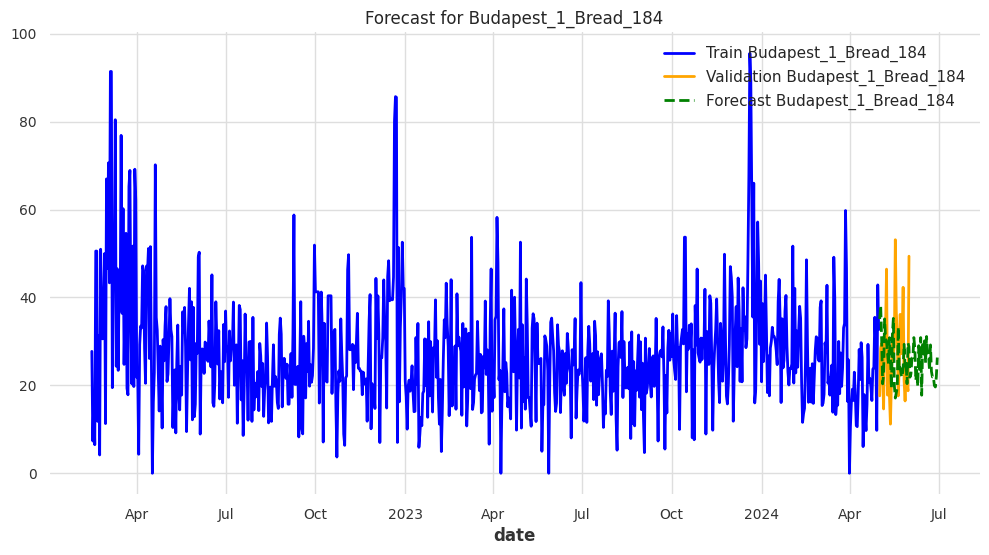

         date      sales
0  2024-05-01  35.100510
1  2024-05-02  38.145787
2  2024-05-03  30.538646
3  2024-05-04  20.342737
4  2024-05-05  22.397526
5  2024-05-06  35.118114
6  2024-05-07  30.692311
7  2024-05-08  30.138616
8  2024-05-09  27.343654
9  2024-05-10  24.865975
10 2024-05-11  30.843442
11 2024-05-12  26.966348
12 2024-05-13  19.371098
13 2024-05-14  31.488449
14 2024-05-15  35.237148
15 2024-05-16  19.958294
16 2024-05-17  17.106135
17 2024-05-18  18.318544
18 2024-05-19  19.506711
19 2024-05-20  33.249725
20 2024-05-21  23.294450
21 2024-05-22  24.007999
22 2024-05-23  22.446516
23 2024-05-24  21.876895
24 2024-05-25  23.840434
25 2024-05-26  29.336572
26 2024-05-27  24.396854
27 2024-05-28  25.320446
28 2024-05-29  20.387034
29 2024-05-30  29.605691
30 2024-05-31  28.817275
31 2024-06-01  21.863394
32 2024-06-02  22.601794
33 2024-06-03  26.183165
34 2024-06-04  26.319863
35 2024-06-05  30.866362
36 2024-06-06  28.347849
37 2024-06-07  21.133128
38 2024-06-08  23.431211


In [ ]:
Budapest_1_Bread_184 = Frankfurt_1_Product[Frankfurt_1_Product['name'] == 'Bread_184']
forecast_Bread_184 = train_and_forecast(
    data= Budapest_1_Bread_184,
    name="Budapest_1_Bread_184",
    input_chunk_length= 365,
    output_chunk_length=60,
    model_type="LSTM",
    random_state=42,
    n_epochs=100,
    batch_size=128,
    dropout=0.5,
    lr=0.1,
    activation="relu"
)

# Opcional: Puedes ver las predicciones de cada almacén
print(forecast_Bread_184)

## Munich_1

In [89]:
# Access the processed data for each warehouse
Munich_1_Product = warehouse_data_product['Munich_1']
print(Munich_1_Product.head(6))

unique_product_names = Munich_1_Product['name'].unique()
print(unique_product_names)

      name       date   sales
0  Apple_6 2022-09-29   52.42
1  Apple_6 2022-09-30  116.90
2  Apple_6 2022-10-01   48.23
3  Apple_6 2022-10-02   29.31
4  Apple_6 2022-10-03   76.07
5  Apple_6 2022-10-04   74.03
['Apple_6' 'Apple_72' 'Asparagus_14' 'Baguette_10' 'Baguette_32'
 'Banana_8' 'Beef_20' 'Beet_4' 'Blueberry_27' 'Bread_10' 'Bread_120'
 'Bread_125' 'Bread_130' 'Bread_184' 'Bread_195' 'Bread_208' 'Bread_217'
 'Bread_223' 'Bread_36' 'Bread_53' 'Bread_58' 'Bread_8' 'Bread_93'
 'Cabbage_14' 'Carrot_25' 'Carrot_6' 'Celery_1' 'Cereal_0' 'Chard_0'
 'Coriander_5' 'Cucumber_33' 'Cucumber_34' 'Donut_21' 'Grape_23'
 'Grape_36' 'Grapefruit_2' 'Kiwi_16' 'Lime_0' 'Lime_5' 'Mint_1'
 'Mix meat_2' 'Mushroom_7' 'Onion_0' 'Onion_15' 'Onion_47' 'Orange_6'
 'Parsley_10' 'Pastry_134' 'Pastry_145' 'Pastry_65' 'Pastry_88'
 'Pepper_16' 'Pepper_4' 'Plant meat_0' 'Potato_30' 'Potato_45' 'Potato_69'
 'Potato_9' 'Roll_16' 'Roll_43' 'Roll_6' 'Salmon_0' 'Sandwich_1'
 'Sandwich_3' 'Sandwich_4' 'Spinach_10' 'Spi

###Munich_1_forecast_Baguette_32

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE for Munich_1_Baguette_32: 32.55


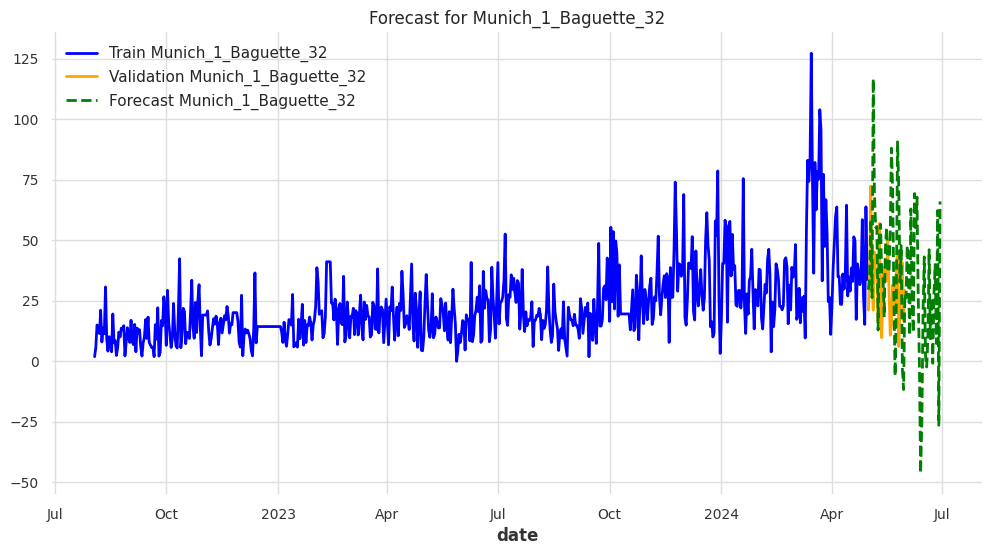

         date       sales
0  2024-05-01   29.541223
1  2024-05-02   35.259867
2  2024-05-03   58.605345
3  2024-05-04   26.326260
4  2024-05-05  116.660246
5  2024-05-06   69.371385
6  2024-05-07   55.330410
7  2024-05-08   55.696294
8  2024-05-09   12.906449
9  2024-05-10   51.346911
10 2024-05-11   56.605034
11 2024-05-12   35.632083
12 2024-05-13   34.971242
13 2024-05-14   18.238752
14 2024-05-15   46.767502
15 2024-05-16   55.346057
16 2024-05-17   37.236491
17 2024-05-18   36.868579
18 2024-05-19   52.982976
19 2024-05-20   88.021813
20 2024-05-21   70.586990
21 2024-05-22   26.429211
22 2024-05-23   -6.099451
23 2024-05-24   24.904382
24 2024-05-25   90.648046
25 2024-05-26   72.317337
26 2024-05-27   32.713745
27 2024-05-28   47.770182
28 2024-05-29   -3.290000
29 2024-05-30  -11.668696
30 2024-05-31   27.762846
31 2024-06-01   26.169744
32 2024-06-02   47.761628
33 2024-06-03   35.551875
34 2024-06-04   10.657933
35 2024-06-05   62.927091
36 2024-06-06   24.451528
37 2024-06-0

In [ ]:
Munich_1_Baguette_32 = Munich_1_Product[Munich_1_Product['name'] == 'Baguette_32']
forecast_Baguette_32 = train_and_forecast(
    data= Munich_1_Baguette_32,
    name="Munich_1_Baguette_32",
    input_chunk_length= 365,
    output_chunk_length=60,
    model_type="LSTM",
    random_state=42,
    n_epochs=100,
    batch_size=128,
    dropout=0.5,
    lr=0.1,
    activation="relu"
)

# Opcional: Puedes ver las predicciones de cada almacén
print(forecast_Baguette_32)

###Munich_1_forecast_Bread_93

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | Metri

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE for Munich_1_Bread_93: 160.10


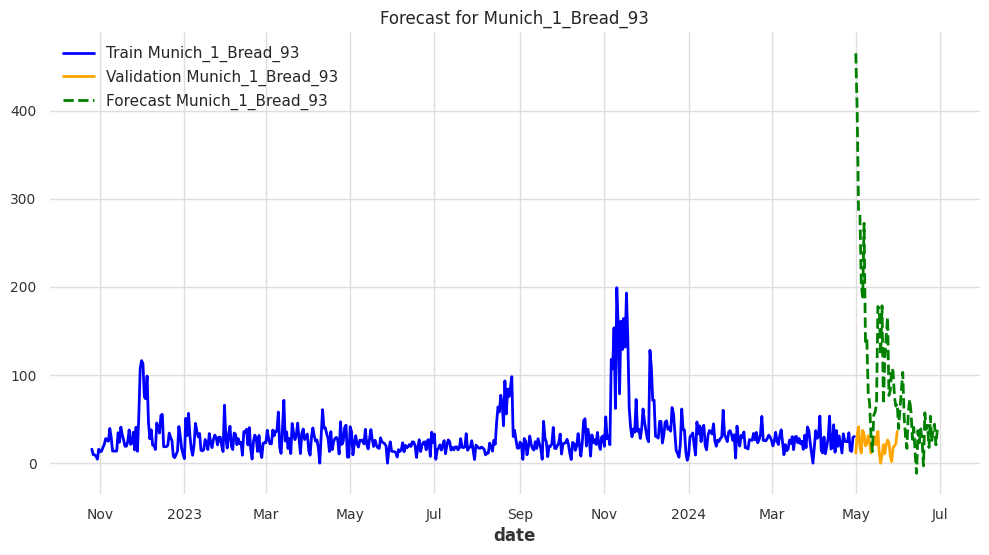

         date       sales
0  2024-05-01  465.082726
1  2024-05-02  399.344158
2  2024-05-03  285.455112
3  2024-05-04  281.795192
4  2024-05-05  201.235710
5  2024-05-06  188.436438
6  2024-05-07  272.166260
7  2024-05-08  136.611843
8  2024-05-09  140.740629
9  2024-05-10   79.416179
10 2024-05-11   68.086531
11 2024-05-12   31.060870
12 2024-05-13   13.248881
13 2024-05-14   54.423844
14 2024-05-15   57.950360
15 2024-05-16   67.096923
16 2024-05-17  177.727704
17 2024-05-18  174.361700
18 2024-05-19  122.452317
19 2024-05-20  178.586527
20 2024-05-21   67.052923
21 2024-05-22  118.210717
22 2024-05-23  143.334247
23 2024-05-24  165.568453
24 2024-05-25   76.856151
25 2024-05-26   82.996511
26 2024-05-27  107.545483
27 2024-05-28  103.921380
28 2024-05-29   75.001496
29 2024-05-30   64.862280
30 2024-05-31   67.585810
31 2024-06-01   39.166286
32 2024-06-02   61.883839
33 2024-06-03   82.487455
34 2024-06-04  102.965925
35 2024-06-05   52.678692
36 2024-06-06   30.481531
37 2024-06-0

In [96]:
Munich_1_Bread_93 = Munich_1_Product[Munich_1_Product['name'] == 'Bread_93']
forecast_Bread_93 = train_and_forecast(
    data= Munich_1_Bread_93,
    name="Munich_1_Bread_93",
    input_chunk_length= 365,
    output_chunk_length=60,
    model_type="LSTM",
    random_state=42,
    n_epochs=150,
    batch_size=64,
    dropout=0.5,
    lr=0.1,
    activation="relu"
)

# Opcional: Puedes ver las predicciones de cada almacén
print(forecast_Bread_93)

# Conclusion

Initially, when using LGBMRegressor to predict sales, it was observed that the independent variables included in the model did not show significant correlations with sales in the correlation analysis. This meant that the chosen variables did not provide relevant information for the prediction, leading to a high error in the estimates, since LightGBM's decision trees tried to fit a pattern that did not actually exist.

For this reason, it was decided to use BlockRNNModel, an approach based on Recurrent Neural Networks (RNN). This change in strategy allowed sales to be modeled based on their history, instead of depending on unimportant external variables. Since sales usually have a strong temporal dependence with seasonal patterns and trends, the use of past sequences as input for the prediction turned out to be a better strategy.

The results showed that the BlockRNNModel generated estimates closer to reality, confirming that the temporal dynamics of sales is key to improving the accuracy of the model. However, it is important to highlight that in order to estimate sales for a specific product, it is necessary to tune the parameters, since sales patterns can vary significantly between products and stores. This means that the model must be tuned by time series to adequately capture the structure of each product.

In conclusion, the change from a decision tree-based model (LGBM) to a recurrent neural network model (BlockRNNModel) allowed to improve the accuracy of the predictions by focusing on the temporal evolution of sales, which turned out to be a more suitable approach to this problem.